In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

In [2]:
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; right: 0px; 
              background: white;
              height: 100%;
              width: 175px; 
              padding: 10px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv>
    <h4>MENU</h4><br>
    <a href=#Data>1. Data</a><br>
    <a href=#Model_Description>2. Model Description</a><br>
    <a href=#Bivariate_Relationships>3. Bivariate Relationships</a><br>
    <a href=#Calibrate_Model>4. Calibration</a><br>
    <a href=#Bootstrap_Model>5. Bootstrap Model</a><br>
    <a href=#Prediction>6. Prediction</a><br><br>

    <a href=#Top>Top</a><br>
    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>

    <h4>PROJECT NOTEBOOKS</h4><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Project_Overview'>Project Overview</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Data_Coverage'>Data Coverage</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/General_Results'>General Results</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Global_Estimate'>Global Estimates</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Crop_Diversity'>Crop Diversity</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Sensitivity_Analyses'>Sensitivity Analyses</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/'>Site Index</a><br>
</div>
''')

<a name="Top"></a>
<center><h1>Global Estimate</h1></center><br><br><br>

In [3]:
import warnings
warnings.filterwarnings('ignore')
import subprocess
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib import colors
import copy
from collections import OrderedDict
from pivottablejs import pivot_ui  # may have to use: python setup.py install --user
import scipy.stats as st
import statsmodels.stats.api as sms
from scipy.stats import linregress
import matplotlib.patches as patches
from sklearn import linear_model
# import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as stats
# from __future__ import print_function
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr

plt.style.use('seaborn-muted')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision',7)

%matplotlib inline

In [4]:
def read_data_init(path):
    
    data = pd.read_csv(path, low_memory=False)

    data['fs_class_max'] = np.where(data['fs_class_max'].isnull(), 10000, data['fs_class_max'])
    data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                bins=[0, 2, 5, 10, 20, 50, 100, 100000])
    
    data = data.replace(0.0, np.nan)  # there were many zero values for production, needed to subset
    
    return data

In [5]:
try:
    PATH_our_data = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    PATH_lowder = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/External_Datasets/Lowder_Supp_cleaned.csv'
    data_orig = read_data_init(PATH_our_data)
    lowder = pd.read_csv(PATH_lowder)
except:
    PATH_our_data = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    PATH_lowder = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/External_Datasets/Lowder_Supp_cleaned.csv'
    data_orig = read_data_init(PATH_our_data)
    lowder = pd.read_csv(PATH_lowder)

# Cclean lowder data to match our data
lowder = lowder.loc[lowder['Holdings/ agricultural area'] == 'Holdings']
lowder = lowder.drop(lowder[[u'year', u'Region', u'Holdings/ agricultural area']], axis=1)

lowder['NAME_0'] = lowder['NAME_0'].str.replace("C\xaate d'Ivoire", "Cote d'Ivoire")
lowder['NAME_0'] = lowder['NAME_0'].str.replace('United States', 'United States of America')
lowder['NAME_0'] = lowder['NAME_0'].str.replace('United States of America of America', 'United States of America')

lowder['(100, 100000]'] = lowder[lowder.columns[-4:]].sum(axis=1)
lowder['(0, 2]'] = lowder[lowder.columns[2:4]].sum(axis=1)
lowder = lowder.iloc[:, [0, 1] + range(4, 9) + [-2, -1]]

In [6]:
# Calculate the mean area per farm size.
# Then multiple the number of farmers by the average farm size class area
# to estimate the ttoal area under each farm size class's management.

b = [3.5, 7.5, 15., 35., 75., 100., 1.]
c = dict(zip(lowder.columns[2:], b))

for key, value in c.iteritems():
    lowder[key] = value * lowder[key]

fs = ['(0, 2]', '(2, 5]', '(5, 10]', 
      '(10, 20]', '(20, 50]', '(50, 100]', 
      '(100, 100000]']

In [7]:
# Import FAOSTAT production, nutrient, and feed, food, other, etc. percentages.
# Harmonize dataset names with ours.

path_fao_prod = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/FaoStat/FAOSTAT/Production_Crops_E_All_Data_(Normalized)_with_regions.csv'
path_fao_nutrients = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FAO_FoodBalance/nutrition.csv'
path_fao_ffo = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FAO_FoodBalance/ffo.csv'

fao_prod = pd.read_csv(path_fao_prod)
fao_nuts = pd.read_csv(path_fao_nutrients)
fao_ffo = pd.read_csv(path_fao_ffo)

fao_prod['Area'] = fao_prod['Area'].str.replace("C\xf4te d'Ivoire", "Cote d'Ivoire")
fao_nuts['NAME_0'] = fao_nuts['NAME_0'].str.replace("C\xf4te d'Ivoire", "Cote d'Ivoire")
fao_ffo['NAME_0'] = fao_ffo['NAME_0'].str.replace("C\xf4te d'Ivoire", "Cote d'Ivoire")

fao_prod['Area'] = fao_prod['Area'].str.replace('Republic of Korea', 'Korea, Rep. of')
fao_nuts['NAME_0'] = fao_nuts['NAME_0'].str.replace('Republic of Korea', 'Korea, Rep. of')
fao_ffo['NAME_0'] = fao_ffo['NAME_0'].str.replace('Republic of Korea', 'Korea, Rep. of')

fao_prod['Area'] = fao_prod['Area'].str.replace('Czechia', 'Czech Republic')
fao_nuts['NAME_0'] = fao_nuts['NAME_0'].str.replace('Czechia', 'Czech Republic')
fao_ffo['NAME_0'] = fao_ffo['NAME_0'].str.replace('Czechia', 'Czech Republic')

In [8]:
has = pd.DataFrame(lowder.NAME_0.unique(), columns=['NAME_0'])
ours = pd.DataFrame(data_orig.query("production_Food_kcal == production_Food_kcal").NAME_0.unique(), 
                    columns=['NAME_0'])

together = pd.merge(has, ours, how='outer', on='NAME_0', indicator=True)
lowder_only = together.loc[together['_merge'] == 'left_only']
together = together.loc[together['_merge'] == 'both']

together = together.drop('_merge', 1)
lowder_only = lowder_only.drop('_merge', 1)

num_tog = len(together.NAME_0.unique())
num_subnational = len(data_orig.query("production_Food_kcal == production_Food_kcal & NAME_1 != '1'").NAME_0.unique())

<a name="Model_Description"></a>
<h2>Model Description</h2><br>

**Goal:**<br><br>
We made a simple model, at the country level, to estimate production of food by farm size<br><br>

<font size="-1">
\begin{align*}
log(Crop \ production_{ft}) = \
        &{} log(Crop \ production \ FAO \ data_{t} * \% \ operational \ holdings_{f}) \ +\\
        &{} log(Growing \ degree \ days_{t}) \ +\\
        &{} log(Growing \ degree \ days_{t}) \ +\\
        &{} log(Percent \ GDP \ from \ agriculture, \ fisheries, \ and \ forests_{t}) \ +\\
        &{} log(Total \ population_{t})
\end{align*}

Where,<br>
f = farm size<br>
t = type of production<br><br>
</font>

<br>
Note: the FAO data does not have production by farm size, but Lowder et al. 2014 has the distributions of farm operations for 111 countries. Combined with our dataset we would have {{num_tog}} country level estimates for the amount of food produced by each farm size, and {{num_subnational}} countries with subnational resolution. 

For the countries not in our dataset we won't have the amount of food produced per farm size. We will need to estimate this based on the FAO data. First, we will measure the relationship between the FAO data and our data - comparing amount of food produced per country without grouping farm sizes. Then we will compare the relationship between the FAO data and our data when we group by farm sizes. The assumption will be that there will be less of a relationship after we group by farm sizes since the FAO production cannot be evenly allocated to each farm size class. To remedy this error, and estimate a better relationship between the FAO data and each of the farm size classes' food production in our data, we will use Lowder et al.'s distribution of farm operations per country. Ideally, we will find the amount of food produced per farm size will be a function of the FAO food production data and Lowder et. al's farm size distributions.

<a name="Data"></a>
<h2>Data</h2><br>

In [9]:
# def pivot1_function(data=data_orig):

#     tmp = data.copy()
    
#     ffo_piv = pd.pivot_table(fao_ffo, index=['NAME_0', 'year'], aggfunc=np.nanmean).reset_index()
#     ffo_piv.columns = list(ffo_piv.columns[:4]) + list(ffo_piv.columns[4:].map(lambda x: x + '_grp'))
#     ffo_piv = ffo_piv.drop('Item_Code', 1)
#     tmp = pd.merge(tmp, ffo_piv, on=['NAME_0', 'year'])

#     tmp['production_kcal'] = tmp['Production_fix'] * tmp['kcal'] * tmp['perc_Other']

#     tmp['Prod_FAO'] = tmp['Area_FAO'] * tmp['Yield_FAO']
#     tmp['Prod_FAO_kcal'] = tmp['Prod_FAO'] * tmp['kcal'] * tmp['perc_Other_grp']

#     pivot = pd.pivot_table(tmp, 
#                            index=['NAME_0', 'NAME_1', 'NAME_2', 'NAME_3', 'year'],
#                            values=['Prod_FAO_kcal', 'production_kcal'],
#                            aggfunc=np.nansum)

#     pivot1 = pivot.reset_index()
    
#     return pivot1
    
    
# pivot1 = pivot1_function(data=data_orig)

In [10]:
def plot_all_fao_v_ours(data, ax=None):

    tmp = data.copy()
    tmp['log_Prod_FAO_kcal'] = np.log(tmp['Prod_FAO_kcal'])
    tmp['log_production_kcal'] = np.log(tmp['production_kcal'])
    tmp = tmp.loc[(np.isfinite(tmp['log_Prod_FAO_kcal'])) & (np.isfinite(tmp['log_production_kcal']))]

    # fig = plt.figure(figsize=[5,5])
    # ax = fig.add_subplot(111)

    x = tmp['log_Prod_FAO_kcal']
    y = tmp['log_production_kcal']

    X = x.as_matrix()
    y = y.as_matrix()
    X = X.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Fit line using all data
    lr = linear_model.LinearRegression(normalize=True)
    lr.fit(X, y)

    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(X, y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    # Predict data of estimated models
    line_X = np.arange(X.min(), X.max())[:, np.newaxis]
    line_y = lr.predict(line_X)
    line_y_ransac = ransac.predict(line_X)

    lw = 2
    ax.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='o',
                label='Inliers')
    ax.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='o',
                label='Potential Outliers')
    ax.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
    ax.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
             label='RANSAC regressor')
    ax.legend(loc='lower right')
    ax.set_xlabel("FAO data produced \n(log kcal)")
    ax.set_ylabel("Our data food produced \n(log kcal)")

    ax.set_title('\n{} \n'
                 'OLS R^2: {} \n'
                 'RANSAC coeff: {} \n '.format('All farms',
                                               round(lr.score(X, y), 2), 
                                               round(ransac.estimator_.coef_, 2)),
                fontsize=14)

    # fig.tight_layout()
    # plt.show()
    
    ceff_ln = round(lr.coef_, 2)
    coeff_rn = round(ransac.estimator_.coef_, 2)
    
    return ax

In [11]:
# tmp['production_fix_kcal'].corr(tmp['Prod_FAO_kcal'], method='spearman')

In [12]:
def prep_plot(data=data_orig, proxy=False, proxy_value='Food'):
    
    tmp = data.copy()
    
    ffo_piv = pd.pivot_table(fao_ffo, index=['NAME_0', 'year'], aggfunc=np.nanmean).reset_index()
    ffo_piv.columns = list(ffo_piv.columns[:4]) + list(ffo_piv.columns[4:].map(lambda x: x + '_grp'))
    ffo_piv = ffo_piv.drop('Item_Code', 1)
    tmp = pd.merge(tmp, ffo_piv, on=['NAME_0', 'year'])
    
    tmp['Prod_FAO'] = tmp['Area_FAO'] * tmp['Yield_FAO']
    
    if proxy is True:

        tmp['Prod_FAO_kcal'] = tmp['Prod_FAO'] * tmp['kcal'] * tmp['perc_{}'.format(proxy_value)]
        tmp['production_kcal'] = tmp['Production_fix'] * tmp['kcal'] * tmp['perc_{}'.format(proxy_value)]

    else:
        
        tmp['Prod_FAO_kcal'] = tmp['Prod_FAO'] * tmp['kcal']
        tmp['production_kcal'] = tmp['Production_fix'] * tmp['kcal'] 

    tmp = tmp.loc[:, ['NAME_0',
                      'Farm_Sizes', 'year', 'production_kcal', 
                      'Prod_FAO_kcal']]
    
    pivot1 = pd.pivot_table(tmp, 
                           index=['NAME_0', 'Farm_Sizes', 'year'],
                           values=['production_kcal'],
                           aggfunc=np.nansum).reset_index()

    pivot2 = pd.pivot_table(tmp, 
                           index=['NAME_0', 'Farm_Sizes', 'year'],
                           values=['Prod_FAO_kcal'],
                           aggfunc=np.nansum).reset_index()

    pivot = pd.merge(pivot1, pivot2, on=['NAME_0', 'year', 'Farm_Sizes'], how='outer')
    pivot = pivot.dropna()

    tmp = pivot.copy()
    tmp['production_kcal'] = np.where(tmp['production_kcal'] == 0.0, np.nan, tmp['production_kcal'])
    tmp['Prod_FAO_kcal'] = np.where(tmp['Prod_FAO_kcal'] == 0.0, np.nan, tmp['Prod_FAO_kcal'])
    tmp['log_Prod_FAO_kcal'] = np.log(tmp['Prod_FAO_kcal'])
    tmp['log_production_kcal'] = np.log(tmp['production_kcal'])
    tmp = tmp.loc[(np.isfinite(tmp['log_Prod_FAO_kcal'])) & (np.isfinite(tmp['log_production_kcal']))]

    return tmp, pivot

In [13]:
tmp, pivot = prep_plot(proxy=False, proxy_value='Food')
pivot_orig = pivot.copy()

First, we plot all the farm size classes together. We can see that there are is a lot of variance. After accounting for the outliers via the RANSAC method, the coefficient is 0.65 (compared to the linear coefficient 0.69). Note, this is a log-log plot as there is heavy skew.

Then, we compare the coefficients when we separate them out by farm size group. As expected, the coefficients decrease in absolute value since the FAO data cannot simply be divided equally and allocated to each far size class. Again, these are a log-log plots as there is heavy skew.

Next, we use Lowder et al. 2014 dataset, we can use the number of farm operations per farm size class. Note, the Lowder et al. data also has area under each farm size class, but only for a select number of countries, which excludes large producers not in our dataset, such as, China).

So here we use the Lowder et al. data and construct percentages of farm operations per farm size class. Then we will test the relationships between the percentage of food produced by a given farm size class and percent of operations by farm size class for each country in our dataset. If there is a strong relationship we can test the error, then predict to countries we do not have in our dataset. Note: Lowder et al.'s data relies on census data ranging from 1987 to 2005, with a median year of 2000 (average 1997). We assume the same distributions in our dataset for the given year we collected data.

We then add control variables to better predict our estimates for the value of production from each farm size class. In our final model we use:

**Farm size to production proxy** - as a best bet farm size distributions tied to production<br>
**Percent GDP from agriculture, forestry, and fisheries** - to incorporate the impact that government support for certain crops influences crop choice and market access<br>
**Growing Degree Days (GDD)** - to incorporate how climate influences crop choice<br>
**Total population** - to incorporate total market for crops which may influence crop choice<br>

In [14]:
try:
    PATH_FAO_GDP = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/FaoStat/FAOSTAT/Macro-Statistics_Key_Indicators_E_All_Data_(Norm).csv'
    df_gdp = pd.read_csv(PATH_FAO_GDP)
except:
    PATH_FAO_GDP = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/FaoStat/FAOSTAT/Macro-Statistics_Key_Indicators_E_All_Data_(Norm).csv'
    df_gdp = pd.read_csv(PATH_FAO_GDP)

df_gdp['Country'] = df_gdp['Country'].str.replace('Samoa', 'American Samoa')
df_gdp['Country'] = df_gdp['Country'].str.replace("C\xf4te d'Ivoire", "Cote d'Ivoire")
df_gdp['Country'] = df_gdp['Country'].str.replace('Republic of Korea', 'Korea, Rep. of')

In [15]:
def add_gdp(data=pivot):

    tmp_gdp = df_gdp.copy()
    tmp_gdp = tmp_gdp.loc[(tmp_gdp['Element'] == 'Value US$, 2005 prices') & 
                          (tmp_gdp['Item'] != 'Gross Fixed Capital Formation'), 
                         ['Country', 'Year', 'Item', 'Value']]

    tmp_gdp = pd.pivot_table(tmp_gdp, index=['Country', 'Year'], columns=['Item'], values='Value').reset_index()
    tmp_gdp = tmp_gdp.sort_values(['Country', 'Year'])

    multi_index = pd.MultiIndex.from_product([tmp_gdp['Country'].unique(),
                                              tmp_gdp['Year'].unique()],
                                             names=['Country', 'Year'])

    tmp_gdp = tmp_gdp.set_index(['Country', 'Year']).reindex(multi_index).reset_index()

    tmp_gdp = tmp_gdp.set_index(['Country', 'Year'])
    tmp_gdp = tmp_gdp.interpolate(method='linear',
                                  axis=0,
                                  limit_direction='both')
    tmp_gdp = tmp_gdp.reset_index()

    data = pd.merge(data, tmp_gdp, 
                    left_on=['NAME_0', 'year'], 
                    right_on=['Country', 'Year'],
                    how='left')
    data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)
    data.rename(columns=lambda x: x.replace(',', ''), inplace=True)
    
    return data

In [16]:
def std_column_func(data, column):
    
    x = data[column]
    xbar = data[column].mean()
    std_ = data[column].std()
    # data[column + '_std'] = (x - xbar) / std_
    data[column + '_std'] = x / x.max()
    
    return data
    
    
def std_column(data=None):

    vars_to_std = ['production_kcal', 
                  # 'Prod_FAO_kcal', 
                   'Proxy_fs',
                   'Perc_Farms',
                   'Gross_Domestic_Product', 
                   'Gross_Domestic_Product_per_capita', 
                   'Value_Added_Agriculture_Forestry_and_Fishing']

    for v in vars_to_std:
        data = std_column_func(data, v)
        data['log_' + v] = np.log(data[v])
        data['log_' + v + '_std'] = np.log(data[v + '_std'])
        
    return data

In [17]:
def add_prod(data=None, fao_prod=None, fao_nuts=None, proxy=False, proxy_value='Food'):

    fao_prod = fao_prod.loc[fao_prod['Element'] == 'Production']

    fao_prod = pd.pivot_table(fao_prod, 
                              index=['Area', 'Year'], 
                              columns=['Item Code'], 
                              values='Value').reset_index()
    
    fao_prod = fao_prod.sort_values(['Area', 'Year'])

    multi_index = pd.MultiIndex.from_product([fao_prod['Area'].unique(),
                                              fao_prod['Year'].unique()],
                                             names=['Area', 'Year'])

    fao_prod = fao_prod.set_index(['Area', 'Year']).reindex(multi_index).reset_index()

    fao_prod = fao_prod.set_index(['Area', 'Year'])
    fao_prod = fao_prod.interpolate(method='linear',
                                  axis=0,
                                  limit_direction='both')
    fao_prod = fao_prod.reset_index()
    fao_prod = pd.melt(fao_prod, id_vars=['Area', 'Year'])
    fao_prod.columns = ['NAME_0', 'year', 'Item_Code', 'value']
    
    fao_prod = pd.merge(fao_prod, 
                        fao_nuts,
                        on=['NAME_0', 'year', 'Item_Code'],
                        how='left')
    
    fao_prod = pd.merge(fao_prod, 
                        fao_ffo,
                        on=['NAME_0', 'year', 'Item_Code'],
                        how='left')
    
    if proxy is True:
        
        fao_prod['Prod_FAO_kcal'] = fao_prod['value'] * fao_prod['kcal'] * fao_prod['perc_{}'.format(proxy_value)] 

    else:
        
        fao_prod['Prod_FAO_kcal'] = fao_prod['value'] * fao_prod['kcal']

        
    fao_prod = pd.pivot_table(fao_prod,
                              index=['NAME_0', 'year'],
                              values='Prod_FAO_kcal',
                              aggfunc=np.nansum).reset_index()

    data = pd.merge(data, fao_prod, 
                    on=['NAME_0', 'year'],
                    how='left')
    
    data = pd.pivot_table(data, 
                          index=['NAME_0', 'year', 'Farm_Sizes', 'Perc_Farms'],
                          values='Prod_FAO_kcal',
                          aggfunc=np.nansum).reset_index()
    
    data['Proxy_fs'] = data['Prod_FAO_kcal'] * data['Perc_Farms']
    
    return data

In [18]:
# Generate two datasets: train, based on our actual data, 
# and predict, based on the data in Lowder but not in our dataset.

def train_predict_dfs(proxy=False, proxy_value='Food'):
    
    gdd_path = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/gdd.csv'
    gdd = pd.read_csv(gdd_path)
    gdd = gdd.loc[:, ['NAME_FAO', 'POPSQKM', 'POP2000', 'zt_mean']]
    gdd.columns = ['NAME_0', 'POPSQKM', 'POP2000', 'zt_mean']

    pop_path = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FAOSTAT_population_data_10-11-2017.csv'
    pop = pd.read_csv(pop_path)
    pop_rural = pop.loc[pop['Element'] == 'Rural population']
    pop_all = pop.loc[pop['Element'] != 'Rural population']
    pop = pd.merge(pop_rural, pop_all, on=['Area', 'Year'], how='outer')
    pop = pop.loc[:, ['Area', 'Year', 'Value_x', 'Value_y']]
    pop.columns = ['NAME_0', 'year', 'Rural_Pop', 'Total_Pop']
    pop['perc_Rural'] = pop['Rural_Pop'] / pop['Total_Pop']
    
    lowder['Total'] = lowder.loc[:, lowder.columns[2:]].sum(axis=1)
    lowder2 = lowder.copy()

    for c in lowder.columns[2:]:
        lowder2[c] = lowder[c] / lowder['Total']

    lowder2 = lowder2.drop(['Total'], axis=1)
    lowder2 = pd.melt(lowder2, id_vars='NAME_0', var_name='Farm_Sizes', value_name='Perc_Farms')

    tmp, pivot_orig = prep_plot(proxy=proxy, proxy_value=proxy_value)
    pivot = pivot_orig.drop('Prod_FAO_kcal', 1)
    train = pd.merge(pivot, lowder2, on=['NAME_0', 'Farm_Sizes'], how='inner')
            
    train = add_prod(data=train, fao_prod=fao_prod, 
                     fao_nuts=fao_nuts, proxy=proxy, proxy_value=proxy_value)
    
    train = add_gdp(data=train)
    train = pd.merge(train, pivot_orig, on=['Farm_Sizes', 'year', 'NAME_0'], how='left')
    train = std_column(train)

    train = pd.merge(train, gdd, on='NAME_0', how='left')
    train = pd.merge(train, pop, on=['NAME_0', 'year'], how='left')
    train['log_zt_mean'] = np.log(train['zt_mean'])
    train['zt_mean_std'] = (train['zt_mean'] - train['zt_mean'].mean()) / train['zt_mean'].std()
    train['log_perc_Rural'] = np.log(train['perc_Rural'])
    train['log_Total_Pop'] = np.log(train['Total_Pop'])
    train['log_Rural_Pop'] = np.log(train['Rural_Pop'])
    train['log_GDP_ag'] = np.log(train['Value_Added_Agriculture_Forestry_and_Fishing'] / 
                                 train['Gross_Domestic_Product'])
    train['log_GDP_ag_per_Ruralcapita'] = np.log((train['Gross_Domestic_Product'] / train['Rural_Pop'])*
                                                 (train['Value_Added_Agriculture_Forestry_and_Fishing'] / 
                                                  train['Gross_Domestic_Product']))


    predict = lowder2.loc[lowder2['NAME_0'].isin(lowder_only['NAME_0'].unique())]
    predict['year'] = 2013
    predict['production_kcal'] = 1
    
    if proxy is True:
        
        predict = add_prod(data=predict, fao_prod=fao_prod, fao_nuts=fao_nuts, 
                           proxy=True, proxy_value=proxy_value)
    
    else:
        
        predict = add_prod(data=predict, fao_prod=fao_prod, fao_nuts=fao_nuts)

            
    predict = add_gdp(data=predict)
    predict['production_kcal'] = 1
    predict = std_column(predict)

    predict = pd.merge(predict, gdd, on='NAME_0', how='left')
    predict = pd.merge(predict, pop, on=['NAME_0', 'year'], how='left')
    predict['log_zt_mean'] = np.log(predict['zt_mean'])
    predict['zt_mean_std'] = (predict['zt_mean'] - predict['zt_mean'].mean()) / predict['zt_mean'].std()
    predict['log_perc_Rural'] = np.log(predict['perc_Rural'])
    predict['log_Total_Pop'] = np.log(predict['Total_Pop'])
    predict['log_Rural_Pop'] = np.log(predict['Rural_Pop'])
    predict['log_GDP_ag'] = np.log(predict['Value_Added_Agriculture_Forestry_and_Fishing'] / 
                                   predict['Gross_Domestic_Product'])

    
    return train, predict
    
    
train, predict = train_predict_dfs(proxy=False, proxy_value='Food')

<a name="Bivariate_Relationships"></a>
<h2>Bivariate Relationships</h2><br>

Our total production vs. proxy value of total production (i.e., Lowder et al. distributions used to disaggregate times FAOSTAT production values)

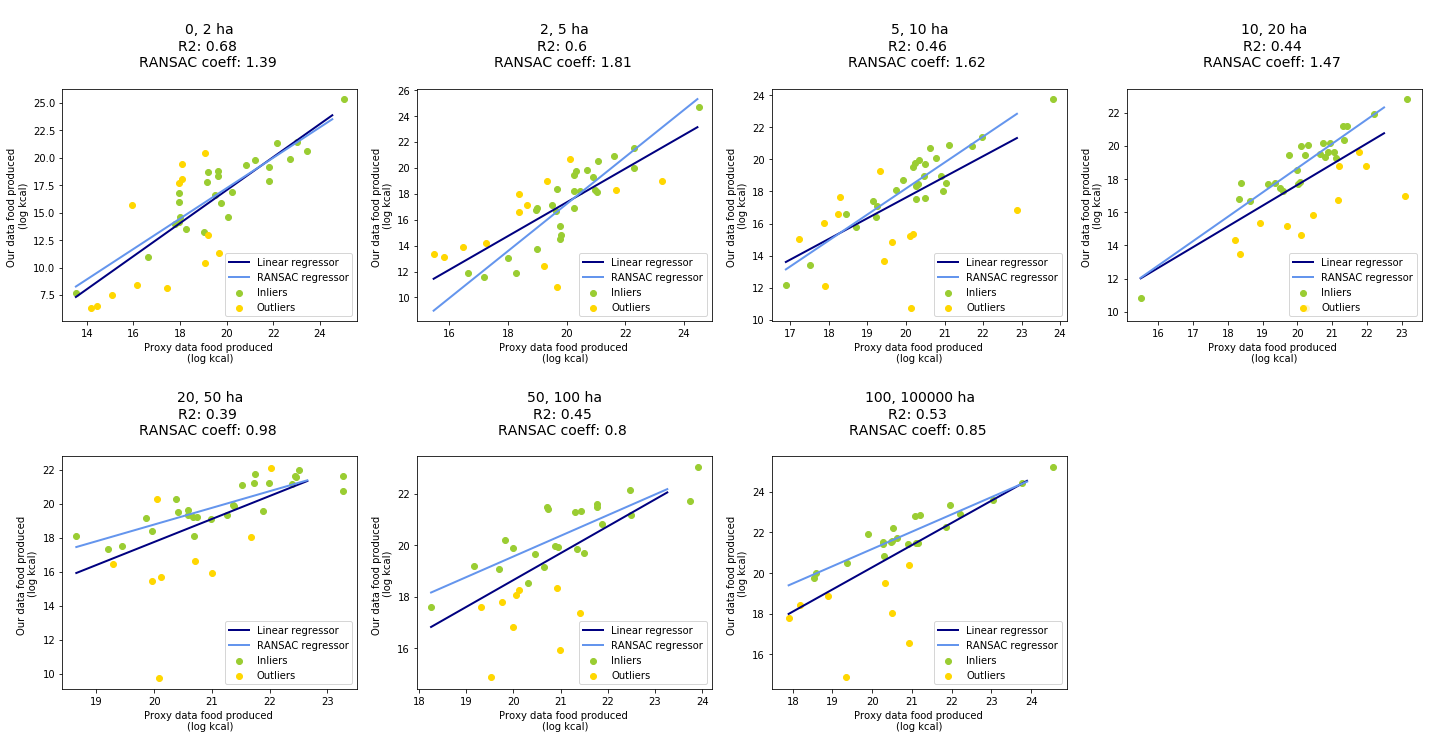

In [19]:
def plot_fao_ours_fs(data, 
                     x_var='log_Proxy_fs', 
                     y_var='log_production_kcal',
                     x_lab='FAO data food produced \n(log kcal)',
                     y_lab='Our data food produced \n(log kcal)'):
    
    fig = plt.figure(figsize=[20,20])

    # ax1 = fig.add_subplot(3,4,8)
    # plot_all_fao_v_ours(pivot1, ax=ax1)

    for i in xrange(0, len(fs)):
        
        tmp2 = data.loc[data['Farm_Sizes'] == fs[i]]
        x = tmp2[x_var]
        y = tmp2[y_var]
        l = linregress(x,y)

        ax = fig.add_subplot(4,4,i+1)

        X = x.as_matrix()
        y = y.as_matrix()
        X = X.reshape(-1, 1)
        y = y.reshape(-1, 1)

        # Fit line using all data
        lr = linear_model.LinearRegression()
        lr.fit(X, y)

        # Robustly fit linear model with RANSAC algorithm
        ransac = linear_model.RANSACRegressor()
        ransac.fit(X, y)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

        # Predict data of estimated models
        line_X = np.arange(X.min(), X.max())[:, np.newaxis]
        line_y = lr.predict(line_X)
        line_y_ransac = ransac.predict(line_X)

        # # Compare estimated coefficients
    #     print("Estimated coefficients (true, linear regression, RANSAC):")
    #     print(lr.coef_, ransac.estimator_.coef_)

        lw = 2
        ax.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='o',
                    label='Inliers')
        ax.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='o',
                    label='Outliers')
        ax.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
        ax.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
                 label='RANSAC regressor')
        ax.legend(loc='lower right')
        ax.set_xlabel(x_lab)
        ax.set_ylabel(y_lab)

        ax.set_title('\n{} ha\n'
                     'R2: {} \n'
                     'RANSAC coeff: {} \n '.format(fs[i][1:-1],
                                                   round(lr.score(X, y), 2), 
                                                   round(ransac.estimator_.coef_, 2)),
                    fontsize=14)
    
    fig.tight_layout()
    
    return plt.show()
    
    
plot_fao_ours_fs(train,
                 x_var='log_Proxy_fs', 
                 y_var='log_production_kcal',
                 x_lab='Proxy data food produced \n(log kcal)',
                 y_lab='Our data food produced \n(log kcal)')

Our total production vs. Gross Domestic Product per capita

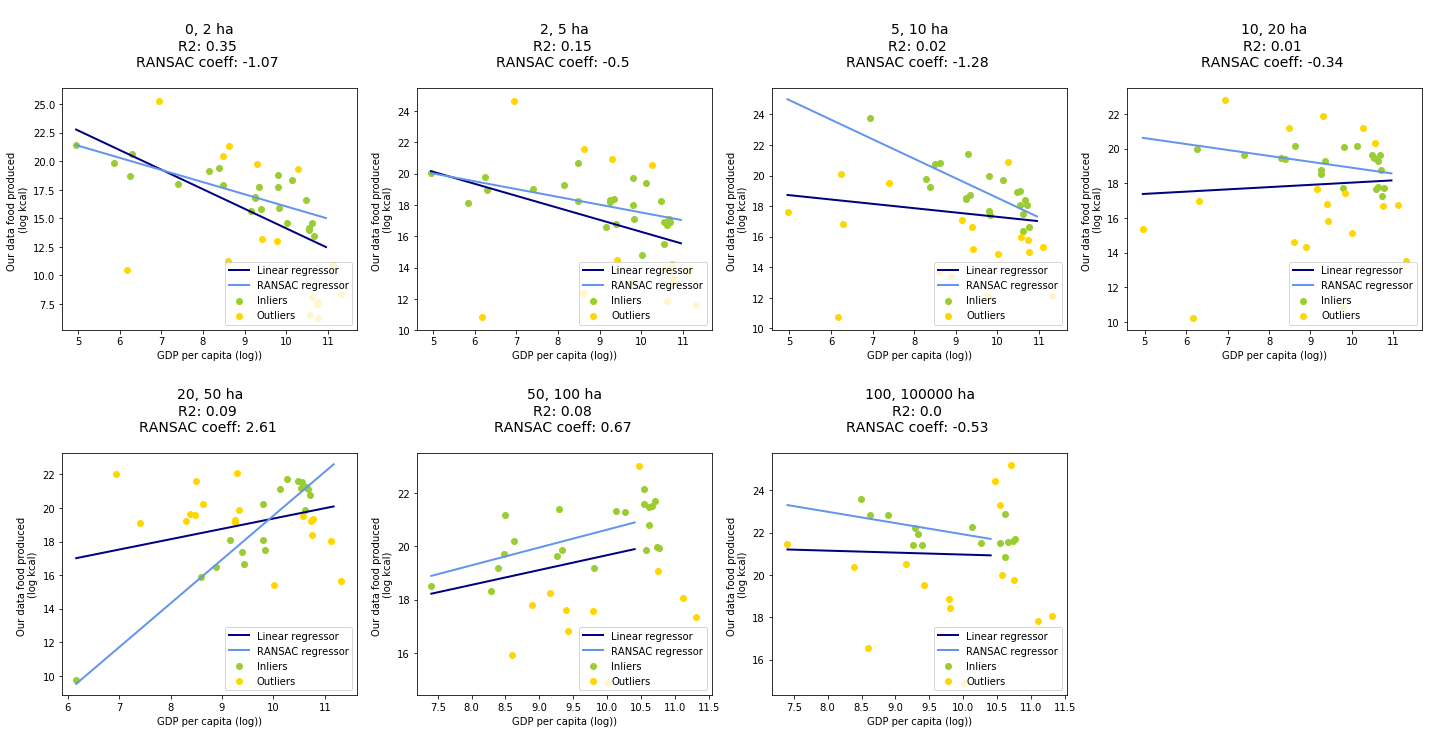

In [20]:
plot_fao_ours_fs(train,
                 x_var='log_Gross_Domestic_Product_per_capita', 
                 y_var='log_production_kcal',
                 x_lab='GDP per capita (log))',
                 y_lab='Our data food produced \n(log kcal)')

Our total production vs. Value added from agriculture, forestry, and fisheries

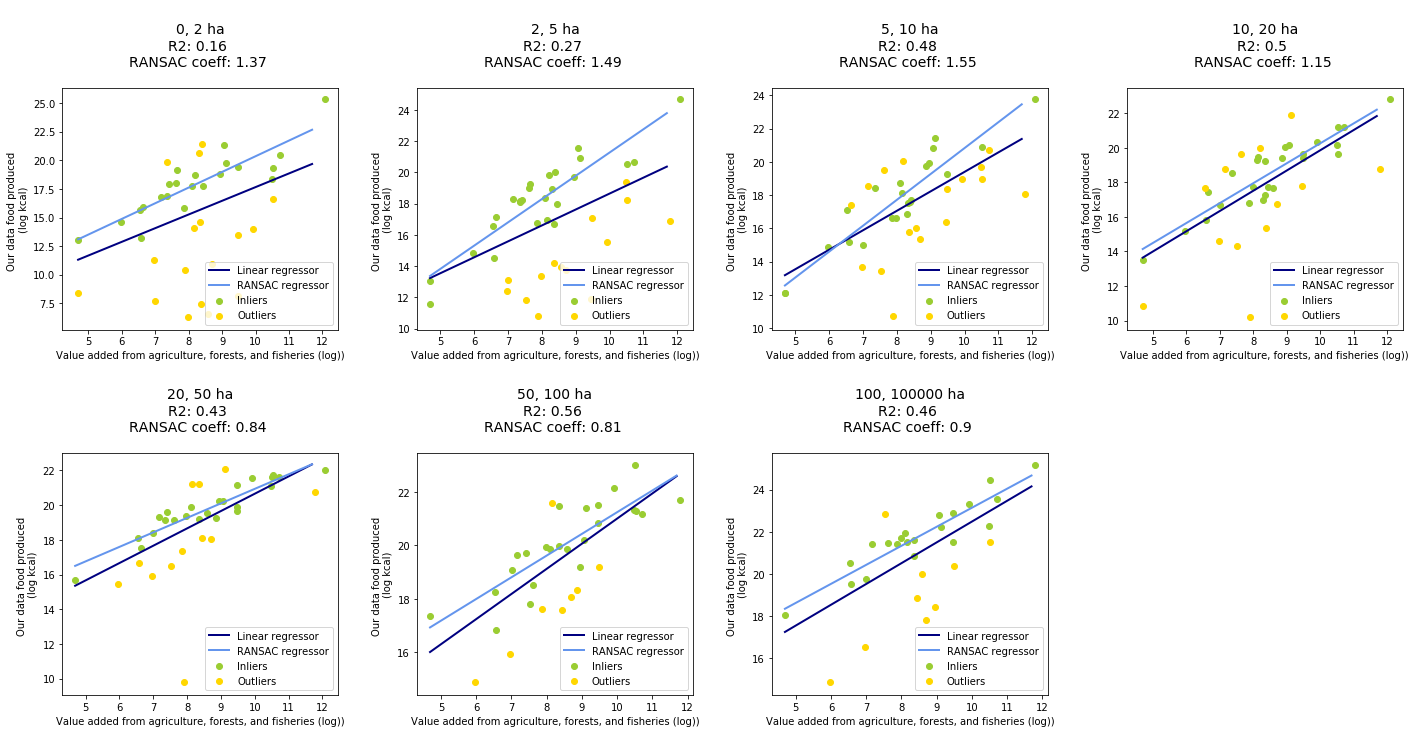

In [21]:
plot_fao_ours_fs(train,
                 x_var='log_Value_Added_Agriculture_Forestry_and_Fishing', 
                 y_var='log_production_kcal',
                 x_lab='Value added from agriculture, forests, and fisheries (log))',
                 y_lab='Our data food produced \n(log kcal)')

Our total production vs. interaction of Gross Domestic Product per capita and Value added from agriculture, forestry, and fisheries

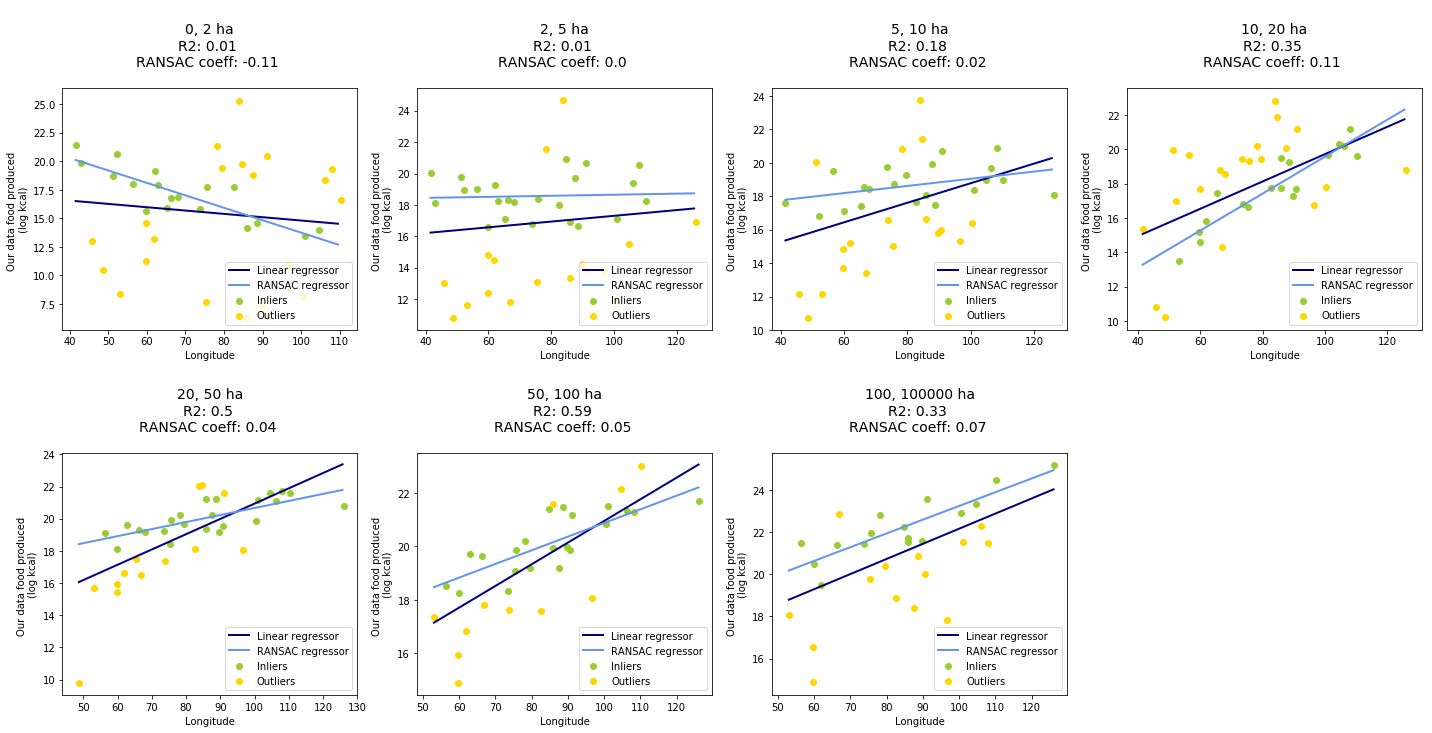

In [22]:
t = train.copy()
t['interaction'] = np.log(t['Gross_Domestic_Product_per_capita']) * np.log(t['Value_Added_Agriculture_Forestry_and_Fishing'])  

plot_fao_ours_fs(t,
                 x_var='interaction', 
                 y_var='log_production_kcal',
                 x_lab='Longitude',
                 y_lab='Our data food produced \n(log kcal)')

Our total production vs. Percent GDP from agriculture, forestry, and fisheries

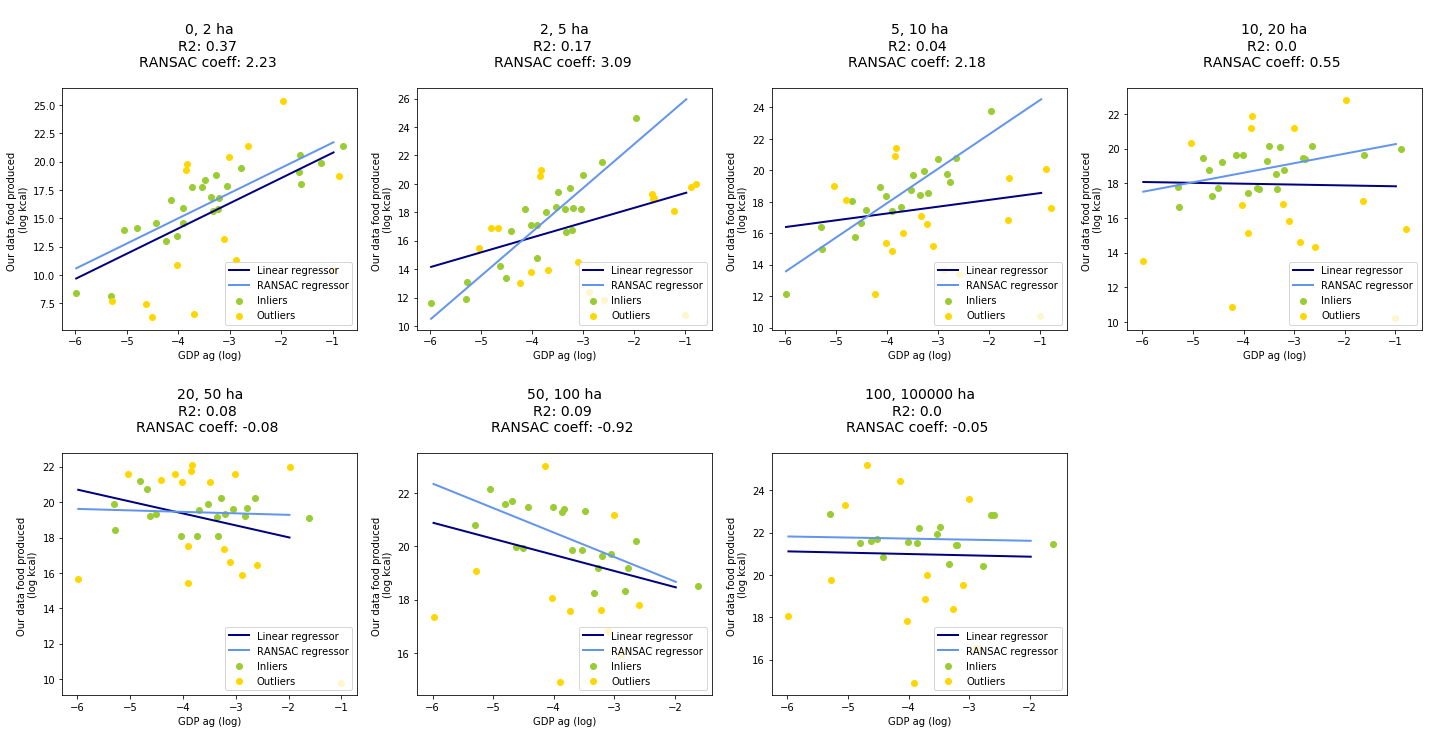

In [23]:
plot_fao_ours_fs(train,
                 x_var='log_GDP_ag', 
                 y_var='log_production_kcal',
                 x_lab='GDP ag (log)',
                 y_lab='Our data food produced \n(log kcal)')

Our total production vs. Average number of growing degree days

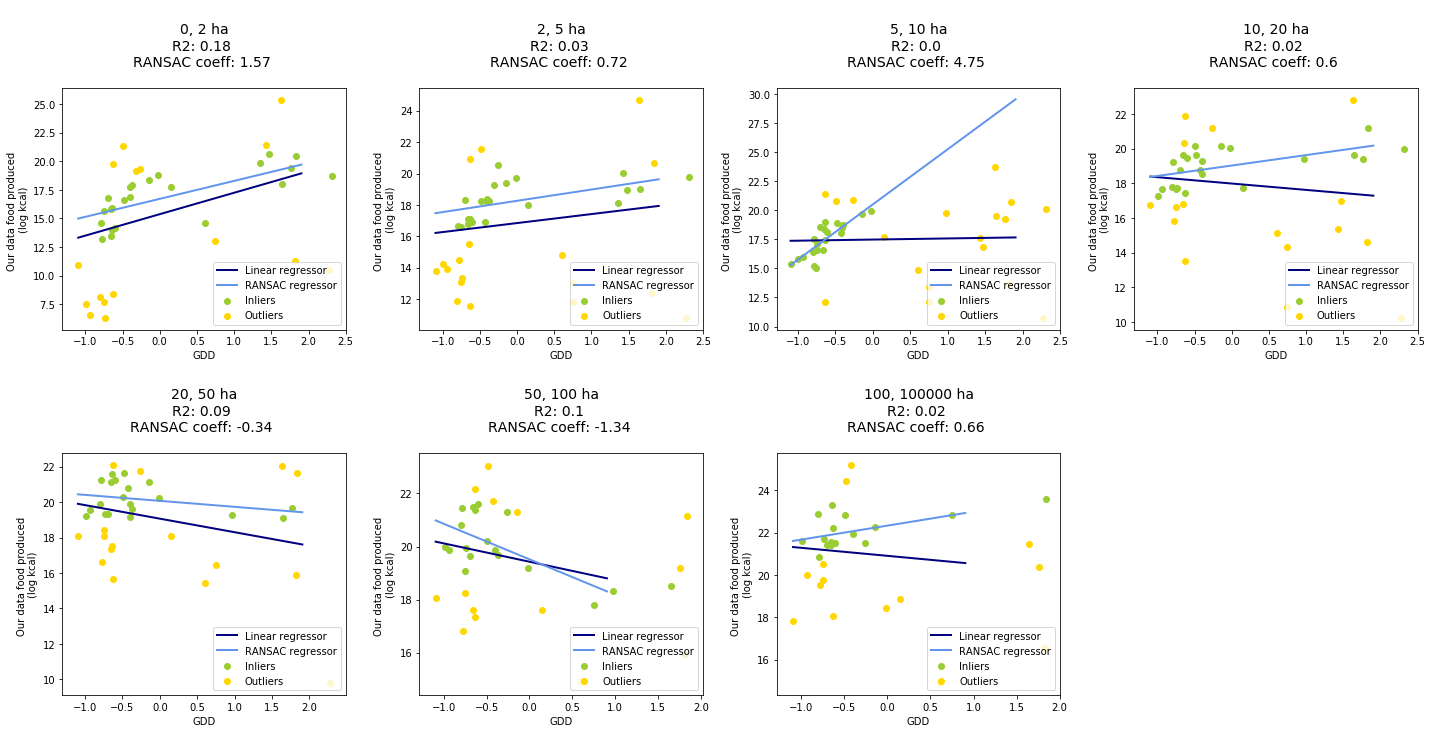

In [24]:
plot_fao_ours_fs(train,
                 x_var='zt_mean_std', 
                 y_var='log_production_kcal',
                 x_lab='GDD',
                 y_lab='Our data food produced \n(log kcal)')

Our total production vs. Total population

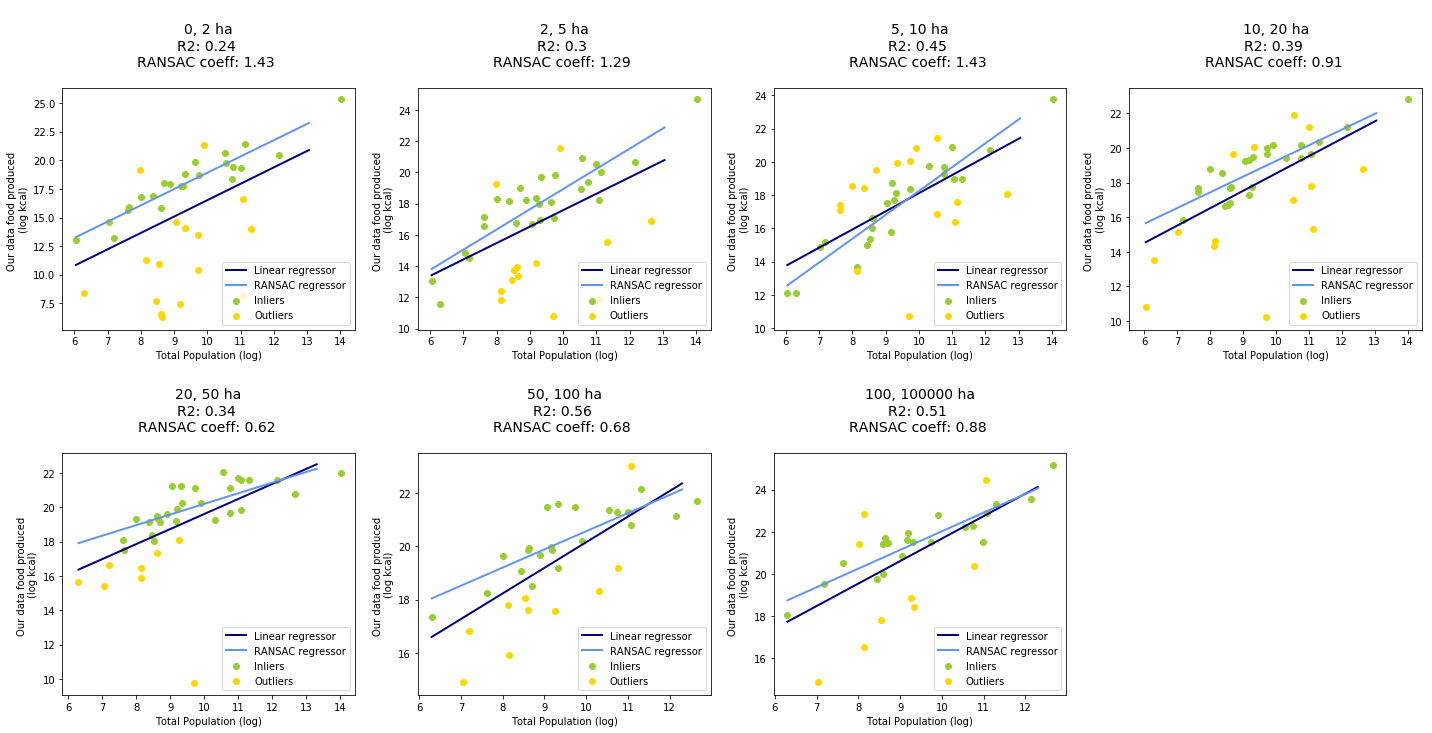

In [25]:
plot_fao_ours_fs(train,
                 x_var='log_Total_Pop', 
                 y_var='log_production_kcal',
                 x_lab='Total Population (log)',
                 y_lab='Our data food produced \n(log kcal)')

Our total production vs. Rural population

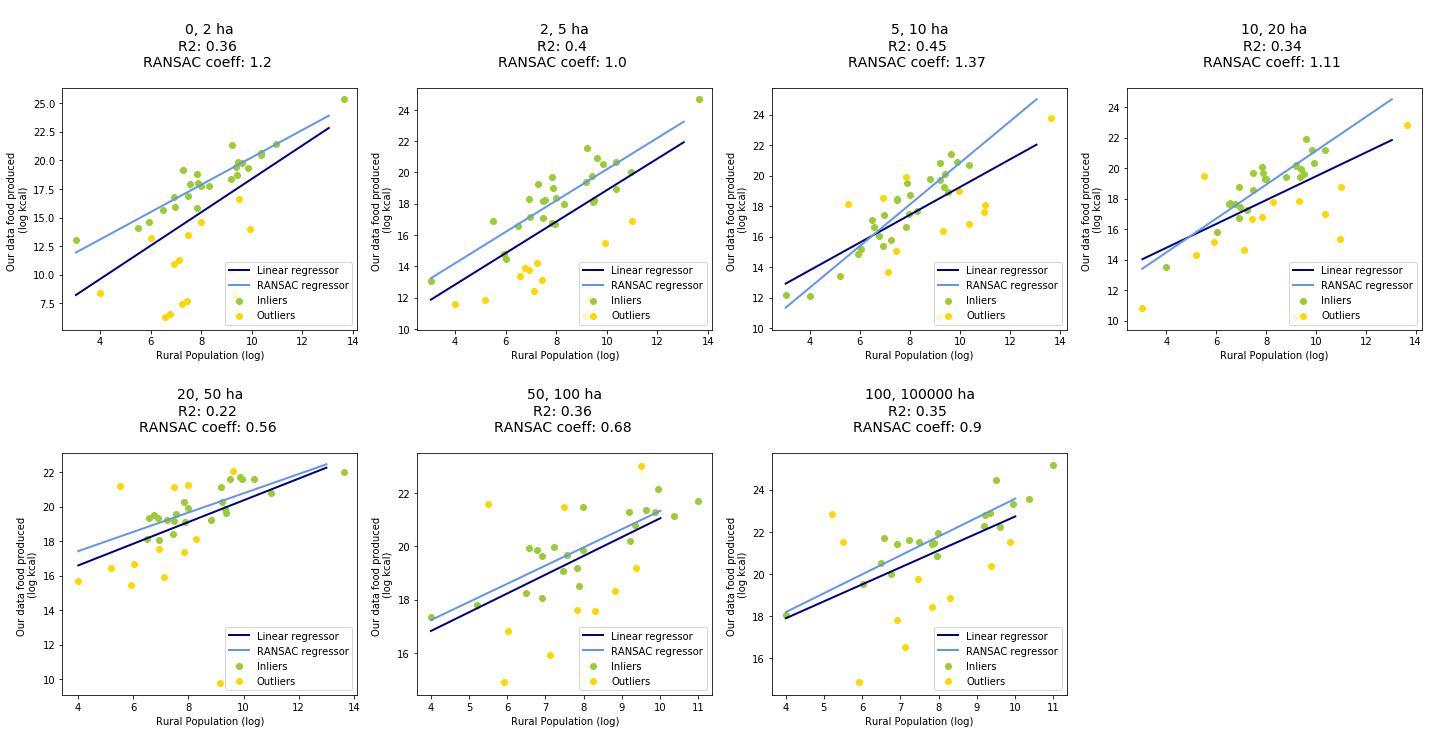

In [26]:
plot_fao_ours_fs(train,
                 x_var='log_Rural_Pop', 
                 y_var='log_production_kcal',
                 x_lab='Rural Population (log)',
                 y_lab='Our data food produced \n(log kcal)')

Our total production vs. Percent rural population

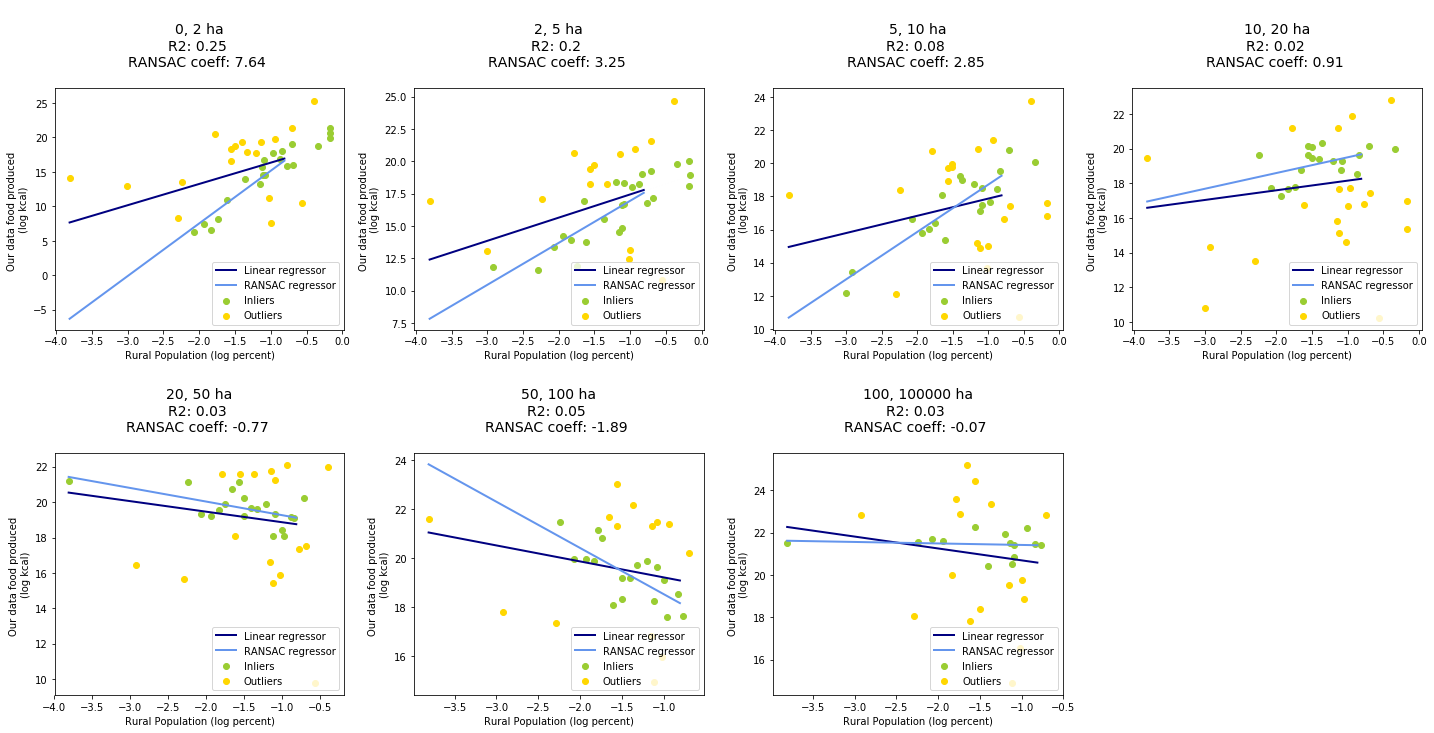

In [27]:
plot_fao_ours_fs(train,
                 x_var='log_perc_Rural', 
                 y_var='log_production_kcal',
                 x_lab='Rural Population (log percent)',
                 y_lab='Our data food produced \n(log kcal)')

Our total production vs. Percent GDP from agriculture, forestry, and fisheries per capita of rural population

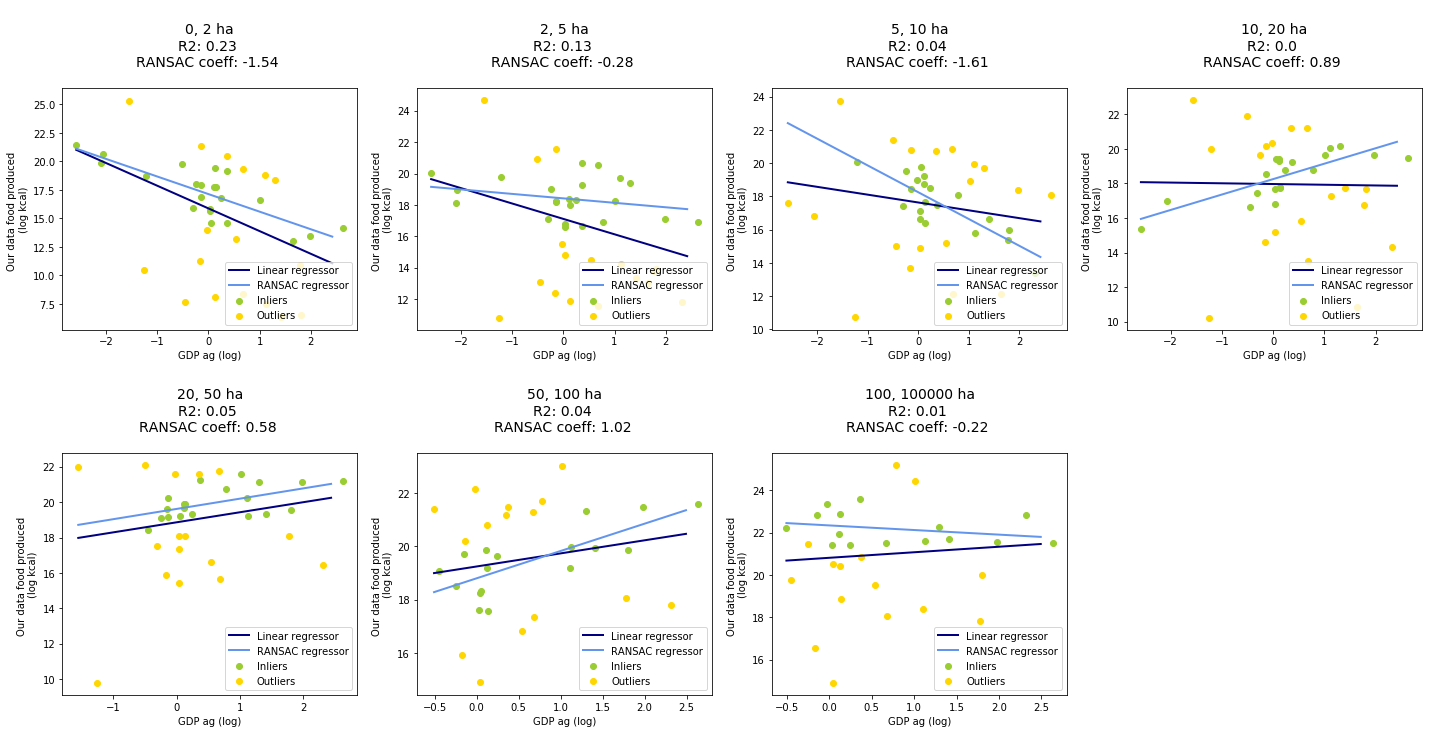

In [28]:
plot_fao_ours_fs(train,
                 x_var='log_GDP_ag_per_Ruralcapita', 
                 y_var='log_production_kcal',
                 x_lab='GDP ag (log)',
                 y_lab='Our data food produced \n(log kcal)')

<a name="Calibrate_Model"></a>
<h2>Calibrate Model</h2><br>

The below output was generated for the 'Food' production category. For our publication we re-ran this section to also include Feed, Processing, Seed, and Other.

In [29]:
def model_prep(data, farmsize=0, xs=[None]):
    
    # Data prep
    fs = data['Farm_Sizes'].unique()

    # Choose farm size
    data = data.loc[data['Farm_Sizes'] == fs[farmsize]]
    data = data.dropna()
    
    names = data['NAME_0']
    
    data['interaction'] = np.log(data['Gross_Domestic_Product_per_capita'] * data['Value_Added_Agriculture_Forestry_and_Fishing'])  
    data['interaction2'] = np.log(data['Proxy_fs'] * data['zt_mean'])  

    xs = xs
    
    # Set exog and endog variables
    data_exog = data.loc[:, xs]
    
    data_exog = data_exog.as_matrix()
    data_exog = sm.add_constant(data_exog)

    data_endog = data.loc[:, ['log_production_kcal']]
    data_endog = data_endog.as_matrix()
    
    return data_endog, data_exog, names
    
    
def ols_model(data, farmsize=0, robust=False, xs=[None]):
    
    data_endog, data_exog, names = model_prep(data, farmsize=farmsize, xs=xs)

    ols_est = sm.OLS(data_endog, data_exog, missing='drop').fit()
    # ols_resid = ols_est.resid
    # resid_fit = sm.OLS(ols_resid[1:], sm.add_constant(ols_resid[:-1])).fit()
    
    if robust is True:
        ols_est = ols_est.get_robustcov_results()
    else:pass
    
    return ols_est, data_endog, data_exog, names, xs  #, ols_resid, resid_fit
    
    
def gls_model(data, farmsize=0, robust=False, xs=[None]):
    
    data_endog, data_exog, names = model_prep(data, farmsize=farmsize, xs=xs)

    glsar_model = sm.GLSAR(data_endog, data_exog, 2)
    gls_results = glsar_model.iterative_fit()
    
    if robust is True:
        gls_results = gls_results.get_robustcov_results(cov_type='HC3')
    else:
        pass
    
    return gls_results, data_endog, data_exog, names, xs
    
    
def model_diagnostic_plots(model, data_endog, xs=[None]):

    print model.summary(xname=['Constant'] + xs)
    
    fig = plt.figure(figsize=[15, 5])
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)

    sns.regplot(np.sqrt(model.resid**2), model.fittedvalues, lowess=True, ax=ax1)
    sns.regplot(model.resid, model.fittedvalues, lowess=True, ax=ax2)
    stats.probplot(model.resid, dist="norm", plot=ax3)
    
    x = data_endog.ravel()
    y = model.fittedvalues
    
    sns.regplot(x, y, robust=True, ax=ax4)
    
    ax4.set_xlim([np.min(x)-3, np.max(x)+3])
    ax4.set_ylim([np.min(y)-3, np.max(y)+3])
    
    ax1.set_title('Residuals Distribution')
    ax2.set_title('Residuals vs. Fitted')
    ax3.set_title('Q-Q Plot')
    ax4.set_title('Actual vs. Fitted')

    fig.tight_layout()
    
    return plt.show()

In [30]:
# To be used in identifying outliers

# def outlier_id():
    # Use for identifying outliers

    # for i in xrange(len(tmp2['NAME_0'].unique())):

    #     print tmp2['NAME_0'].unique()[i]

    #     data = tmp2.loc[tmp2['NAME_0'] != tmp2['NAME_0'].unique()[i]]

    #     ols_est = ols_model(data, farmsize=3)
    # #     ols_est = ols_est.get_robustcov_results()
    #     gls_est = gls_model(data, farmsize=3)
    #     gls_est = gls_est.get_robustcov_results()

    #     print 'Adj r^2', '  Farm Size'
    #     print 'OLS  GLS'
    #     print'-----------------------'

    #     print round(ols_est.rsquared_adj, 2), round(gls_est.rsquared_adj, 2)
    # #     model_diagnostic_plots(ols_est)
    #     model_diagnostic_plots(gls_est)

In [31]:
# sets exogenous variables
xs = ['log_Proxy_fs',  # farm size to production proxy
      'log_GDP_ag',    # percent GDP from agriculture, forestry, and fisheries
      'log_zt_mean',   # growing degree days
      'log_Total_Pop'] # total population

# For each prodcution type (e.g., food, feed, other, etc.) change proxy_value accordingly

train, predict = train_predict_dfs(proxy=True, proxy_value='Food')

Adj r^2   Farm Size
OLS  GLS
-----------------------
0.71 0.83 (0, 2]
                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.851
Model:                          GLSAR   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     54.74
Date:                Wed, 01 Nov 2017   Prob (F-statistic):           7.31e-14
Time:                        12:59:01   Log-Likelihood:                -84.507
No. Observations:                  37   AIC:                             179.0
Df Residuals:                      32   BIC:                             187.1
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

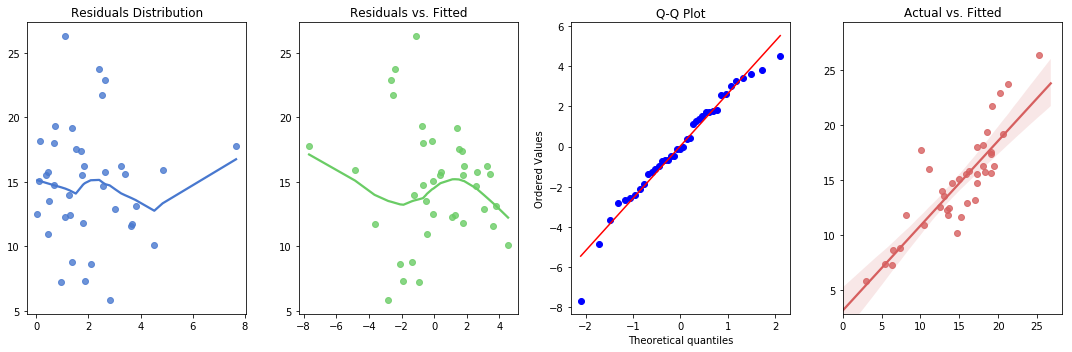

Adj r^2   Farm Size
OLS  GLS
-----------------------
0.61 0.7 (2, 5]
                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.731
Model:                          GLSAR   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     53.36
Date:                Wed, 01 Nov 2017   Prob (F-statistic):           5.97e-14
Time:                        12:59:07   Log-Likelihood:                -76.447
No. Observations:                  38   AIC:                             162.9
Df Residuals:                      33   BIC:                             171.1
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

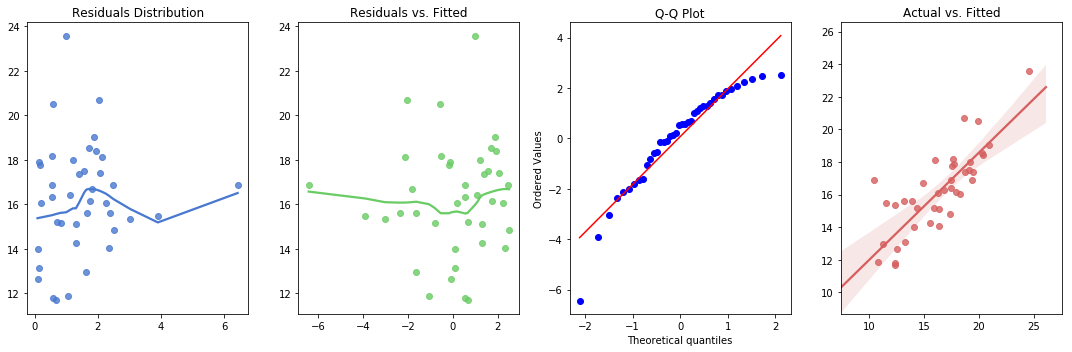

Adj r^2   Farm Size
OLS  GLS
-----------------------
0.49 0.57 (5, 10]
                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.621
Model:                          GLSAR   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     15.62
Date:                Wed, 01 Nov 2017   Prob (F-statistic):           3.47e-07
Time:                        12:59:12   Log-Likelihood:                -70.749
No. Observations:                  37   AIC:                             151.5
Df Residuals:                      32   BIC:                             159.6
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

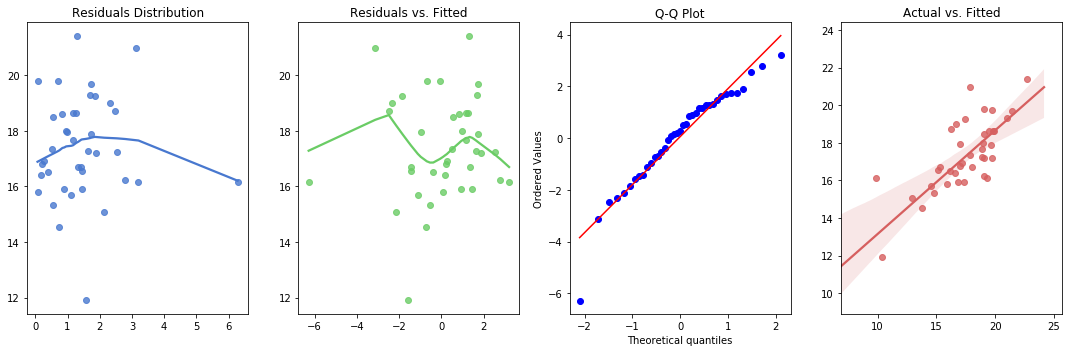

Adj r^2   Farm Size
OLS  GLS
-----------------------
0.71 0.73 (10, 20]
                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.771
Model:                          GLSAR   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     17.73
Date:                Wed, 01 Nov 2017   Prob (F-statistic):           9.11e-07
Time:                        12:59:18   Log-Likelihood:                -42.525
No. Observations:                  28   AIC:                             95.05
Df Residuals:                      23   BIC:                             101.7
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

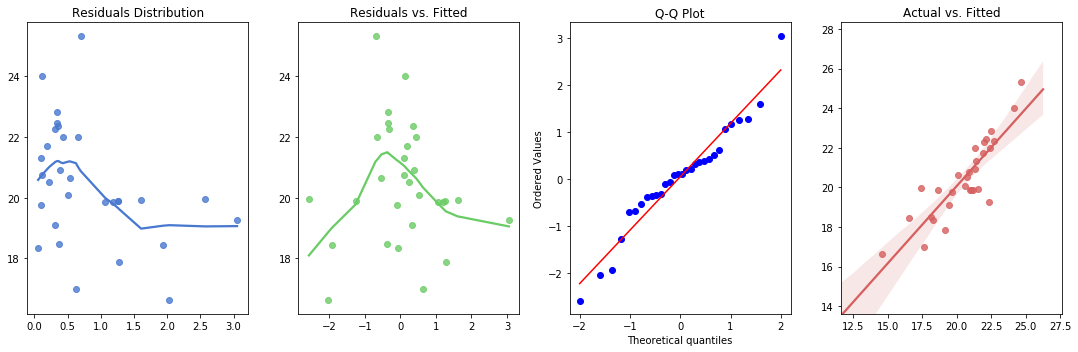

Adj r^2   Farm Size
OLS  GLS
-----------------------
0.48 0.48 (20, 50]
                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.547
Model:                          GLSAR   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     10.03
Date:                Wed, 01 Nov 2017   Prob (F-statistic):           3.19e-05
Time:                        12:59:24   Log-Likelihood:                -65.008
No. Observations:                  34   AIC:                             140.0
Df Residuals:                      29   BIC:                             147.6
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

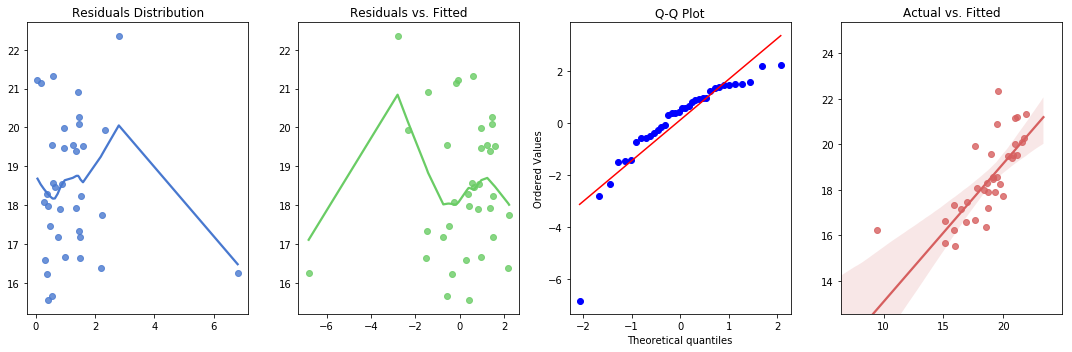

Adj r^2   Farm Size
OLS  GLS
-----------------------
0.51 0.69 (50, 100]
                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.723
Model:                          GLSAR   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     26.44
Date:                Wed, 01 Nov 2017   Prob (F-statistic):           9.55e-10
Time:                        12:59:30   Log-Likelihood:                -69.864
No. Observations:                  37   AIC:                             149.7
Df Residuals:                      32   BIC:                             157.8
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

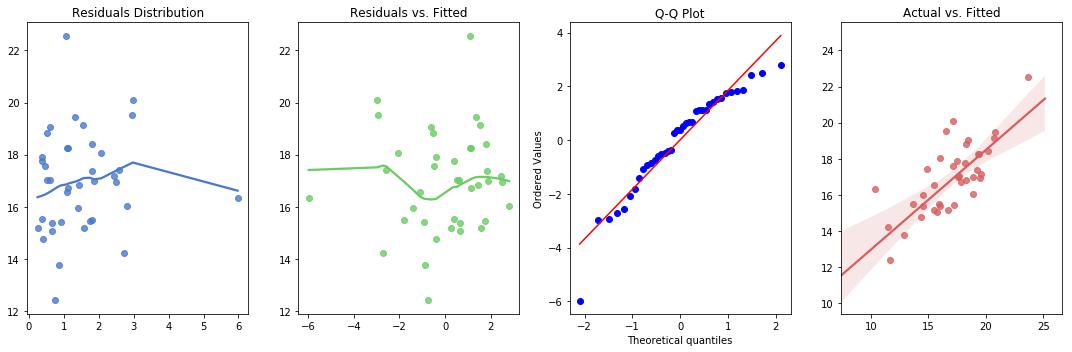

Adj r^2   Farm Size
OLS  GLS
-----------------------
0.68 0.73 (100, 100000]
                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.770
Model:                          GLSAR   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     7.850
Date:                Wed, 01 Nov 2017   Prob (F-statistic):           0.000305
Time:                        12:59:36   Log-Likelihood:                -39.351
No. Observations:                  30   AIC:                             88.70
Df Residuals:                      25   BIC:                             95.71
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

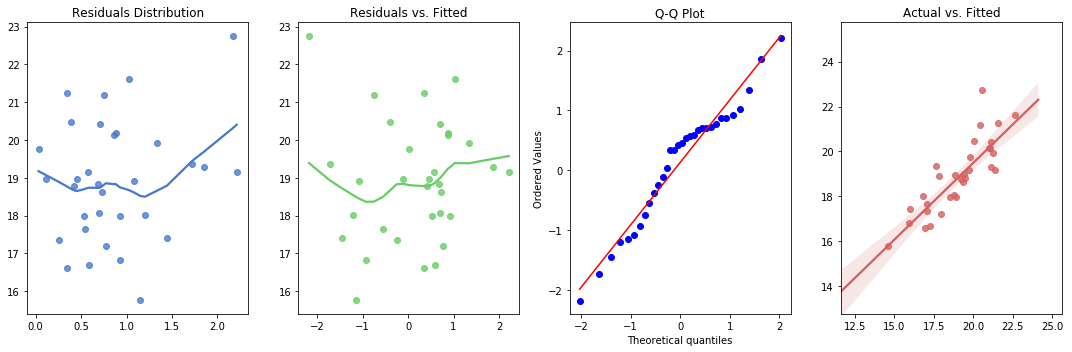

In [32]:
# Summary table and diagnostic plots

for i in xrange(len(fs)):

    # data = tmp2.loc[tmp2['NAME_0'] != 'Mali']  # previous outlier when not grouped classes, had a lot of leverage
    data = train.copy()
    ols_est, data_endog, data_exog, names, xs1 = ols_model(data, farmsize=i, robust=True, xs=xs)
    gls_est, data_endog, data_exog, names, xs = gls_model(data, farmsize=i, robust=True, xs=xs)
    
    print 'Adj r^2', '  Farm Size'
    print 'OLS  GLS'
    print'-----------------------'

    print round(ols_est.rsquared_adj, 2), round(gls_est.rsquared_adj, 2), fs[i]
    model_diagnostic_plots(gls_est, data_endog, xs=xs)

Compare OLS to GLS model results

In [33]:
# Compares OLS and GLS results

def run_models():

    print 'Adj r^2', '       Farm Size'
    print 'OLS  GLS  BIC'
    print'---------------------'

    rs = []
    bs = []

    for i in xrange(len(fs)):

        data = train.copy()
        # data = tmp2.loc[tmp2['NAME_0'] != 'Mali']  # outlier, had a lot of leverage

        # ols_est, data_endog, data_exog, names = ols_model(data, farmsize=i)
        ols_est, data_endog, data_exog, names, xs1 = ols_model(data, farmsize=i, robust=True, xs=xs)

        # gls_est, data_endog, data_exog, names = gls_model(data, farmsize=i)
        gls_est, data_endog, data_exog, names, xs1 = gls_model(data, farmsize=i, robust=True, xs=xs)

        predicted = pd.Series(np.exp(gls_est.fittedvalues)).reset_index(drop=True)        
        names = names.reset_index(drop=True)

        out = pd.concat([pd.DataFrame(names, columns=['NAME_0']),
                         pd.DataFrame(predicted, columns=['predicted'])],
                        axis=1)

        out['Farm_Sizes'] = fs[i]

        if i is 0:
            out2 = out.copy()
        else:
            out2 = pd.concat([out2, out], axis=0)

        print round(ols_est.rsquared_adj, 2), round(gls_est.rsquared_adj, 2), round(gls_est.bic, 2), fs[i]
        rs.append(gls_est.rsquared_adj)
        bs.append(gls_est.bic)


    print '\nMean R2: ', round(np.nanmean(rs), 2)
    print 'Mean BICs: ', round(np.nanmean(bs), 2)

    pivot1 = pd.pivot_table(out2, 
                            index=['NAME_0', 'Farm_Sizes'],
                            aggfunc=np.nansum).reset_index()

    pivot2 = pd.pivot_table(out2, 
                            index=['NAME_0'],
                            aggfunc=np.nansum).reset_index()

    pivot = pd.merge(pivot1, pivot2, on='NAME_0')
    pivot['perc_predicted'] = pivot['predicted_x'] / pivot['predicted_y']
    pivot['Farm_Sizes'] = pivot['Farm_Sizes_x']
    pivot = pivot.loc[:, ['NAME_0', 'Farm_Sizes', 'perc_predicted']]

    pivot3 = pd.pivot_table(data, 
                            index=['NAME_0', 'Farm_Sizes'],
                            values='production_kcal',
                            aggfunc=np.nansum).reset_index()

    pivot4 = pd.pivot_table(data, 
                            index=['NAME_0'],
                            values='production_kcal',
                            aggfunc=np.nansum).reset_index()

    pivot5 = pd.merge(pivot3, pivot4, on='NAME_0')
    pivot5['perc_actual'] = pivot5['production_kcal_x'] / pivot5['production_kcal_y']

    compare = pd.merge(pivot5, pivot, on=['NAME_0', 'Farm_Sizes'], how='inner')
    compare.columns = ['NAME_0', 'Farm_Sizes', 'actual', 'predicted', 'perc_actual', 'perc_predicted']

    dictionary = dict(zip(fs, range(0, len(fs))))  # used to circumvent categorical indexing
    compare['ix'] = compare['Farm_Sizes'].map(dictionary)
    
    return compare
    
    
compare = run_models()

Adj r^2        Farm Size
OLS  GLS  BIC
---------------------
0.71 0.83 187.07 (0, 2]
0.61 0.7 171.08 (2, 5]
0.49 0.57 159.55 (5, 10]
0.71 0.73 101.71 (10, 20]
0.48 0.48 147.65 (20, 50]
0.51 0.69 157.78 (50, 100]
0.68 0.73 95.71 (100, 100000]

Mean R2:  0.68
Mean BICs:  145.79


Plot comparisons between actual and predicted

Actual vs. Predicted
                 r   p
Spearman rank:   0.51  0.0
Wilcoxon t-test: 12754.0  0.04


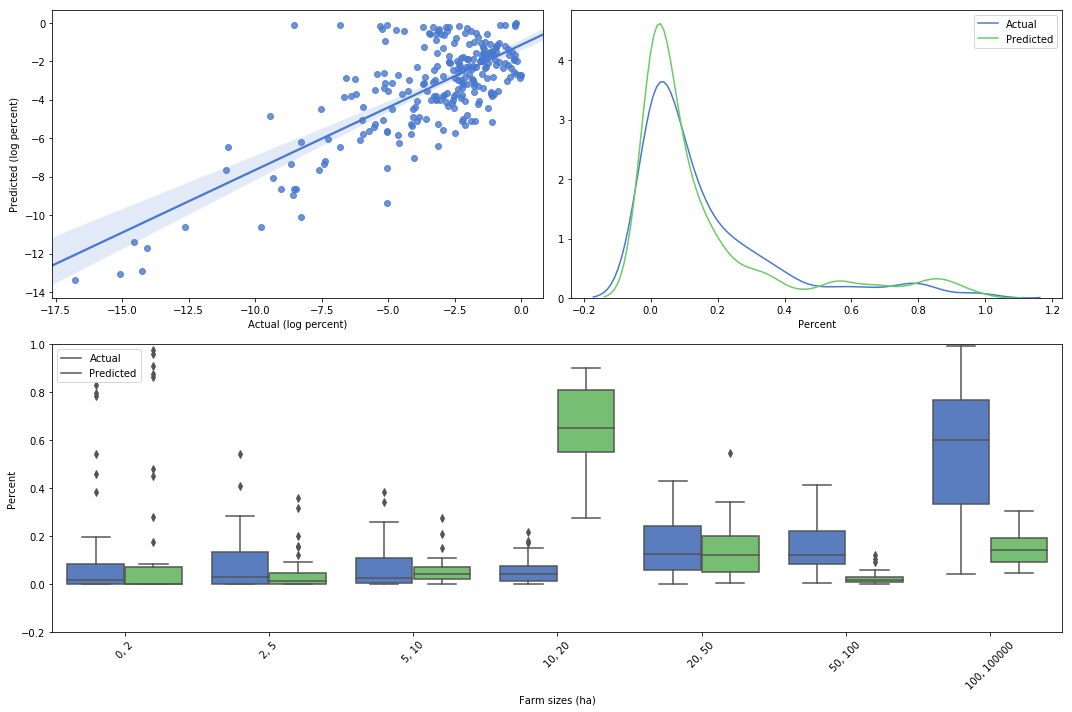

In [34]:
# Plots comparisons between actual and predicted

x = compare['perc_actual']
y = compare['perc_predicted']

sr, sp =  spearmanr(x, y)
wr, wp = stats.wilcoxon(x, y, correction=True)

print 'Actual vs. Predicted'
print '                 r   p'
print 'Spearman rank:   {}  {}'.format(round(sr,2), round(sp, 2))
print 'Wilcoxon t-test: {}  {}'.format(round(wr,2), round(wp, 2))


fig = plt.figure(figsize=[15, 10])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

# sns.regplot(x, y, robust=True, ax=ax1)
sns.regplot(np.log(x), np.log(y), ax=ax1)
ax1.set_xlabel('Actual (log percent)')
ax1.set_ylabel('Predicted (log percent)')

sns.distplot(x, hist=False, label='Actual', ax=ax2)
sns.distplot(y, hist=False, label='Predicted', ax=ax2)
ax2.set_xlabel('Percent')
# ax2.set_ylim([0,0.2])

compare2 = compare.loc[:, ['NAME_0', 'ix', 'Farm_Sizes', 'perc_actual', 'perc_predicted']]
melted = pd.melt(compare2, 
                 id_vars=['NAME_0', 'ix', 'Farm_Sizes'])
# melted['value'] = np.log(melted['value'])

sns.boxplot(x='ix', y='value', data=melted, hue='variable', bootstrap=1000, ax=ax3)
ax3.set_xticklabels([x[1:-1] for x in fs], rotation=45)
ax3.set_xlabel('Farm sizes (ha)')
ax3.set_ylabel('Percent')
ax3.legend(title='', labels=['Actual', 'Predicted'], loc='upper left')
ax3.set_ylim([-0.2, 1])


fig.tight_layout()
plt.show()

Cohen's d, Farm Size
0.14 (0, 2]
0.37 (2, 5]
0.22 (5, 10]
4.25 (10, 20]
0.08 (20, 50]
1.57 (50, 100]
2.12 (100, 100000]


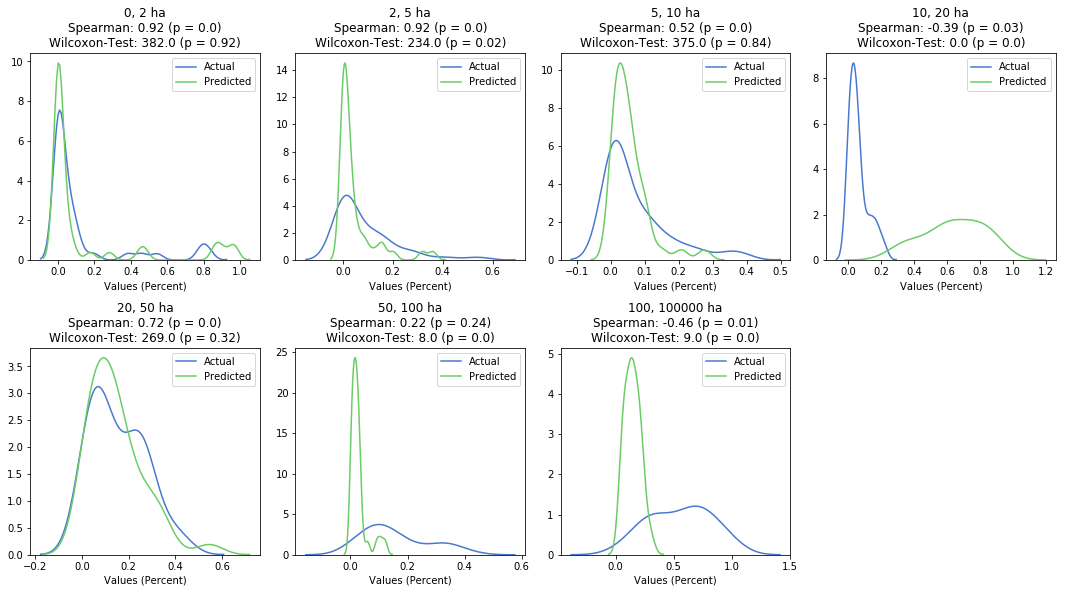

In [35]:
# Plots comparisons between actual and predicted 2

print "Cohen's d, Farm Size"

fig = plt.figure(figsize=[15,12])

for i in xrange(len(fs)):
    
    t = compare.loc[compare['Farm_Sizes'] == fs[i]]
    x = t['perc_actual']
    y = t['perc_predicted']
    
    r, p = spearmanr(x, y)
    t, tp = stats.wilcoxon(x, y, zero_method='zsplit', correction=True)
    spooled = np.sqrt((x.std()**2 + y.std()**2) / 2)
    cd = (x.mean() - y.mean()) / spooled
    
    ax = fig.add_subplot(3,4,i+1)
    sns.kdeplot(x, ax=ax)
    sns.kdeplot(y, ax=ax)
    ax.legend(labels=['Actual', 'Predicted'])
    ax.set_xlabel('Values (Percent)')
    ax.set_title(str(fs[i][1:-1]) + ' ha\nSpearman: {} (p = {})\nWilcoxon-Test: {} (p = {})'.format(
        round(r, 2), round(p, 2),
        round(t, 2), round(tp, 2)))
    
    print round(np.abs(cd), 2), fs[i]
    
fig.tight_layout()    
plt.show();

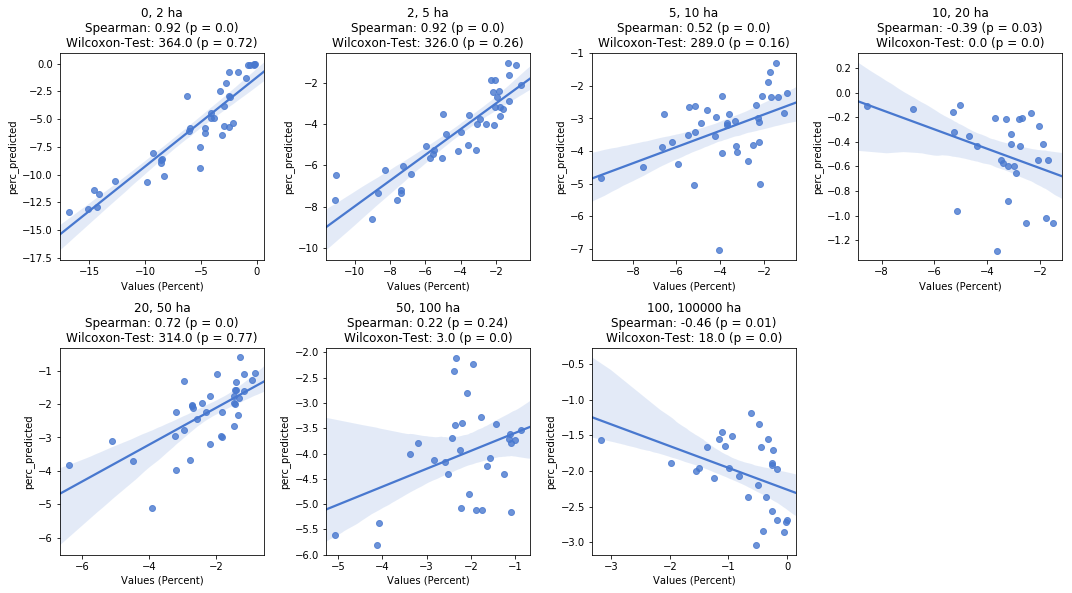

In [36]:
# Plots comparisons between actual and predicted 3

fig = plt.figure(figsize=[15,12])

for i in xrange(len(fs)):
    
    t = compare.loc[compare['Farm_Sizes'] == fs[i]]
    x = np.log(t['perc_actual'])
    y = np.log(t['perc_predicted'])
    
    r, p = spearmanr(x, y)
    t, tp = stats.wilcoxon(x, y, zero_method='zsplit', correction=True)
    spooled = np.sqrt((x.std()**2 + y.std()**2) / 2)
    cd = (x.mean() - y.mean()) / spooled
    
    ax = fig.add_subplot(3,4,i+1)
    sns.regplot(x, y, ax=ax)
    ax.set_xlabel('Values (Percent)')
    ax.set_title(str(fs[i][1:-1]) + ' ha\nSpearman: {} (p = {})\nWilcoxon-Test: {} (p = {})'.format(
        round(r, 2), round(p, 2),
        round(t, 2), round(tp, 2)))
    
fig.tight_layout()    
plt.show();

Below is a summary table of all models used.

In [37]:
# Generates summary table of all models used for publication

for t in ['Feed', 'Food', 'Processing', 'Seed', 'Waste', 'Other']:
 
    train, predict = train_predict_dfs(proxy=True, proxy_value=t)
    
    for i in xrange(len(fs)):
        
        gls_est, data_endog, data_exog, names, xs = gls_model(train, 
                                                              farmsize=i, 
                                                              robust=True, 
                                                              xs=xs)
        
        cs = gls_est.params
        ses = gls_est.bse
        ps = gls_est.pvalues
        r = gls_est.rsquared_adj
        
        out = pd.DataFrame(columns=['types', 
                                    'Farm_Sizes',  
                                    'rsquare',
                                    'n'])

        out['types'] = [t]
        out['Farm_Sizes'] = [fs[i]]
        out['rsquare'] = [r]
        out['n'] = [len(data_exog)]
        
        for j in xrange(5):
            out['coeff_{}'.format(j)] = [cs[j]]
            out['se_{}'.format(j)] = [ses[j]]
            out['pvalue_{}'.format(j)] = [ps[j]]

        
        if t is 'Feed' and i is 0:
            out2 = out.copy()
        else:
            out2 = pd.concat([out2, out], axis=0)  

In [38]:
out3 = out2.copy()

for i in xrange(5):
    out3['x{}'.format(i)] = out3['coeff_{}'.format(i)].apply(lambda x: str(round(x, 2))) + \
                            ' (' + out3['se_{}'.format(i)].apply(lambda x: str(round(x, 2))) + ')'
    out3['x{}'.format(i)] = np.where(out3['pvalue_{}'.format(i)] <= 0.001, out3['x{}'.format(i)] + '***',
                                     np.where(out3['pvalue_{}'.format(i)] <= 0.05, out3['x{}'.format(i)] + '**',
                                              np.where(out3['pvalue_{}'.format(i)] <= 0.1, out3['x{}'.format(i)] + '*',
                                                       out3['x{}'.format(i)])))

out3['Farm_Sizes'] = out3['Farm_Sizes'].apply(lambda x: x[1:-1]).str.replace(', ', ' - ')
out3['Farm_Sizes'] = np.where(out3['Farm_Sizes'] == '0 - 2', '< 2', out3['Farm_Sizes'])
out3['Farm_Sizes'] = np.where(out3['Farm_Sizes'] == '100 - 100000', '> 100', out3['Farm_Sizes'])
    

out3 = out3.loc[:, ['types', 'Farm_Sizes', 'x0', 'x1', 'x3', 'x2', 'x4', 'rsquare', 'n']]

out3.columns = ['Type', 
                'Farm Size', 
                'Constant', 
                'log(Proxy)', 
                'log(Growing Degree Days)', 
                'log(GDP from Agriculture)', 
                'log(Total population)',
                'Adj. R2',
                'N']

out3[''] = ''
out3[' '] = ''

def prep_concat(i1, i2):
    
    data = out3.loc[(out3['Type'] == i1) | (out3['Type'] == i2)]
    data['Adj. R2'] = data['Adj. R2'].apply(lambda x: round(x, 2))
    data['Type'] = np.where(data['Farm Size'] == '< 2', data['Type'], '')
    data = data.transpose()
    
    return data

A = prep_concat('Feed', 'Food')
B = prep_concat('Processing', 'Seed')
C = prep_concat('Waste', 'Other')

out = pd.concat([A, B, C])

out.to_csv('/home/vinny_ricciardi/Downloads/test.csv')

In [39]:
out

,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Type,Feed,,,,,,,Food,,,,,,
Farm Size,< 2,2 - 5,5 - 10,10 - 20,20 - 50,50 - 100,> 100,< 2,2 - 5,5 - 10,10 - 20,20 - 50,50 - 100,> 100
Constant,-11.76 (13.08),0.04 (6.67),7.56 (7.41),13.91 (4.06)**,7.95 (6.42),2.55 (8.37),11.13 (3.75)**,-10.79 (8.69),-3.54 (6.27),3.59 (8.93),13.21 (7.02)*,8.49 (8.9),-3.01 (8.94),11.67 (5.78)*
log(Proxy),1.4 (0.39)***,0.88 (0.26)**,0.5 (0.16)**,0.85 (0.17)***,0.55 (0.27)**,0.63 (0.22)**,0.55 (0.17)**,1.15 (0.2)***,0.89 (0.2)***,0.62 (0.24)**,0.72 (0.24)**,0.53 (0.35),0.78 (0.25)**,0.38 (0.22)*
log(Growing Degree Days),-0.23 (1.3),-0.62 (0.72),-1.12 (0.55)*,-1.83 (0.57)**,-1.25 (0.53)**,-0.76 (0.63),-1.35 (0.4)**,0.31 (1.01),-0.18 (0.64),-0.71 (0.56),-1.62 (0.68)**,-1.12 (0.52)**,-0.29 (0.56),-1.06 (0.44)**
log(GDP from Agriculture),0.72 (0.76),0.23 (0.45),-0.25 (0.54),0.63 (0.29)**,-0.32 (0.77),-0.15 (0.61),0.24 (0.23),1.01 (0.57)*,0.3 (0.42),-0.21 (0.57),0.66 (0.37)*,-0.2 (0.63),-0.23 (0.61),0.11 (0.26)
log(Total population),0.52 (0.37),0.54 (0.27)*,0.79 (0.16)***,0.61 (0.21)**,0.8 (0.19)***,0.78 (0.21)***,0.79 (0.16)***,0.56 (0.29)*,0.54 (0.23)**,0.67 (0.19)***,0.82 (0.26)**,0.75 (0.24)**,0.65 (0.21)**,0.87 (0.17)***
Adj. R2,0.65,0.55,0.56,0.8,0.51,0.6,0.84,0.83,0.7,0.57,0.73,0.48,0.69,0.73
N,39,40,39,30,36,39,32,39,40,39,30,36,39,32
,,,,,,,,,,,,,,


<a name="Prediction"></a>
<h2>Prediction</h2><br>

Two methods were tested to incorporate the predicted values into our dataset. In the end, we decided to use create a predictive model for each production type (e.g., food, feed, other, etc.) per farm size class (Method 1). This resulted in 42 models as seen in the table above. The alternate method (Method 2) was to build one model for total crop production then disaggregate the predicted production into the production type categories (e.g., feed, food, other, etc.). Logically, the latter method would introduce error but would allow for more samples per model and less overall models. Method 1 resulted in sufficient sample sizes per model and similar fits (AIC, BIC) to Method 2.

#### Method 1 (Used in final product)
Model each feed, food, other, etc. separately as an outcome variable.

In [40]:
def predicted_model(xs=[None], proxy=False, proxy_value='Other'):
    
    train, predict = train_predict_dfs(proxy=proxy, proxy_value=proxy_value)    
    
    for i in xrange(len(fs)):
        
        gls_est, data_endog, data_exog, names, xs1 = gls_model(train, 
                                                               farmsize=i, 
                                                               robust=True, 
                                                               xs=xs)
        
        p_subset = predict.loc[predict['Farm_Sizes'] == fs[i]]
        names = p_subset['NAME_0']
        data_exog_predict = p_subset.loc[:, xs]
        data_exog_predict = data_exog_predict.as_matrix()
        data_exog_predict = sm.add_constant(data_exog_predict)
        
        names = names.reset_index(drop=True) 
        predicted = gls_est.get_prediction(data_exog_predict)
        out = predicted.summary_frame()
        out['NAME_0'] = names
        out = out.dropna()
        out['Farm_Sizes'] = fs[i]

        if i is 0:
            out2 = out.copy()
        else:
            out2 = pd.concat([out2, out], axis=0)

    pivot1 = pd.pivot_table(out2, 
                            index=['NAME_0', 'Farm_Sizes'],
                            aggfunc=np.nansum).reset_index()

    pivot2 = pd.pivot_table(out2, 
                            index=['NAME_0'],
                            aggfunc=np.nansum).reset_index()

    pivot = pd.merge(pivot1, pivot2, on='NAME_0')
    pivot['perc_predicted'] = pivot['mean_x'] / pivot['mean_y']
    pivot['Farm_Sizes'] = pivot['Farm_Sizes_x']
    pivot = pivot.loc[:, ['NAME_0', 
                          'Farm_Sizes', 
                          'mean_x', 
                          'mean_ci_lower_x', 
                          'mean_ci_upper_x', 
                          'perc_predicted']]

    pivot.columns = ['NAME_0', 
                     'Farm_Sizes', 
                     'predicted', 
                     'ci_lower', 
                     'ci_upper', 
                     'perc_predicted']
    
    for i in ['predicted', 'ci_lower', 'ci_upper']:
        pivot[i] = np.exp(pivot[i])

    pivot = pivot.dropna()
    
    dictionary = dict(zip(fs, range(0, len(fs))))  # used to circumvent categorical indexing
    pivot['ix'] = pivot['Farm_Sizes'].map(dictionary)
    
    return pivot
    
    
pred = predicted_model(xs=xs, proxy=True, proxy_value='Other')

In [41]:
for i in ['Food', 'Feed', 'Seed', 'Processing', 'Waste', 'Other']:
    pred = predicted_model(xs=xs, proxy=True, proxy_value=i)
    pred = pred.loc[:, ['NAME_0', 'Farm_Sizes', 'predicted', 'ix']]
    pred.columns = ['NAME_0', 'Farm_Sizes', 'production_{}_kcal'.format(i), 'ix']
    
    if i is 'Food':
        out = pred.copy()
    else:
        out = pd.merge(out, pred, on=['NAME_0', 'Farm_Sizes', 'ix'], how='outer')

out.to_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/predicted_data_means.csv')

#### Method two
Model total production, then take FAO food balance sheets' means for percent food, feed, other, etc.


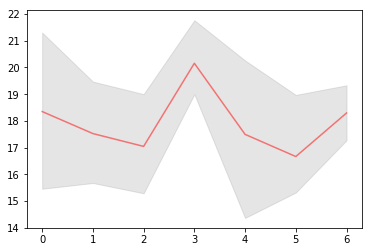

In [42]:
pred = predicted_model(xs=xs, proxy=False, proxy_value=None)
pred2 = pred.copy() 

for i in ['predicted', 'ci_lower', 'ci_upper']:
    pred2[i] = np.log(pred2[i])
    
plt.fill_between(range(7), 
                 pred2.groupby('ix').median()['ci_upper'], 
                 pred2.groupby('ix').median()['ci_lower'],
                 color='grey',
                 alpha=0.2)

plt.plot(range(7), pred2.groupby('ix').median()['predicted'], '-r', alpha=0.5);

In [43]:
ffo_piv = pd.pivot_table(fao_ffo, index=['NAME_0', 'year'], aggfunc=np.nanmean).reset_index()

pred['year'] = 2013.
pivot = pd.merge(pred, ffo_piv,
                 on=['NAME_0', 'year'],
                 how='left')

ffo = ['production_Food_kcal',
       'production_Feed_kcal',
       'production_Seed_kcal',
       'production_Waste_kcal',
       'production_Processing_kcal',
       'production_Other_kcal']

pivot['total'] = pivot.iloc[:, -6:].sum(axis=1)

for i in ffo:
    pivot[i] = pivot['perc_' + i[11:-5]] / pivot['total']

In [44]:
means = pivot.copy()
uppers = pivot.copy()
lowers = pivot.copy()

for i in ffo:
    means[i] = means['perc_' + i[11:-5]] * means['predicted']
    uppers[i] = uppers['perc_' + i[11:-5]] * uppers['ci_upper']
    lowers[i] = lowers['perc_' + i[11:-5]] * lowers['ci_lower']

means = means.loc[:, ['NAME_0', 'year', 'Farm_Sizes'] + ffo]
uppers = uppers.loc[:, ['NAME_0', 'year', 'Farm_Sizes'] + ffo]
lowers = lowers.loc[:, ['NAME_0', 'year', 'Farm_Sizes'] + ffo]

# means.to_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/predicted_data_means.csv')
# uppers.to_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/predicted_data_uppers.csv')
# lowers.to_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/predicted_data_lowers.csv')